C:\Users\fahds\AppData\Local\Temp\ipykernel_92416\878885802.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10")


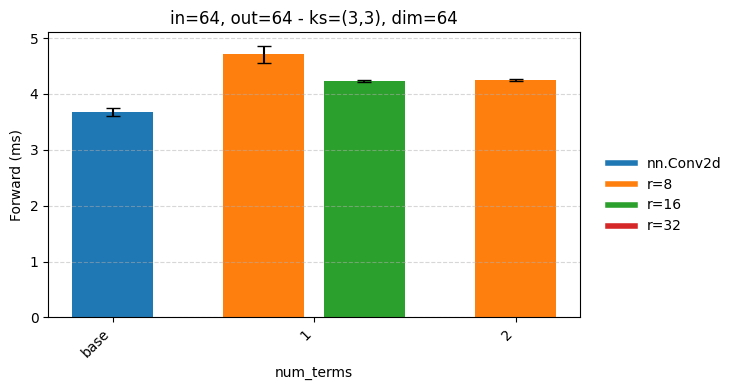

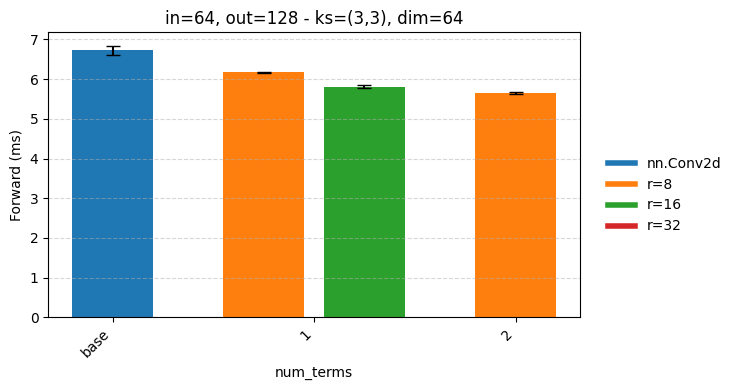

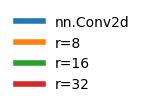

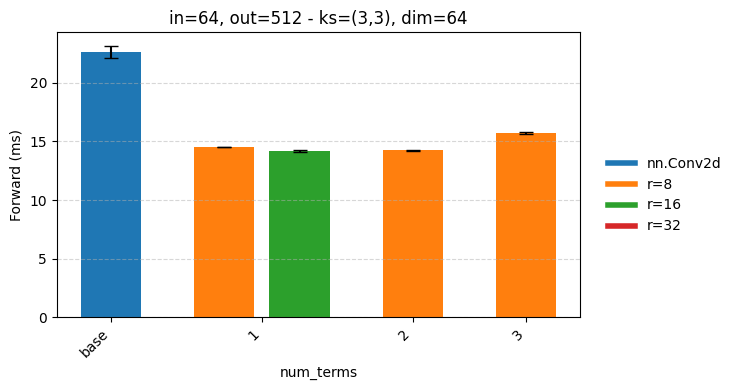

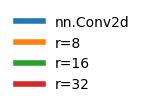

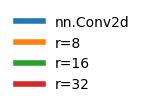

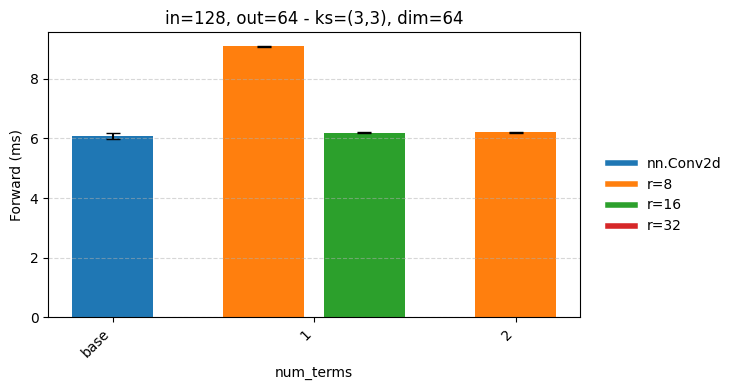

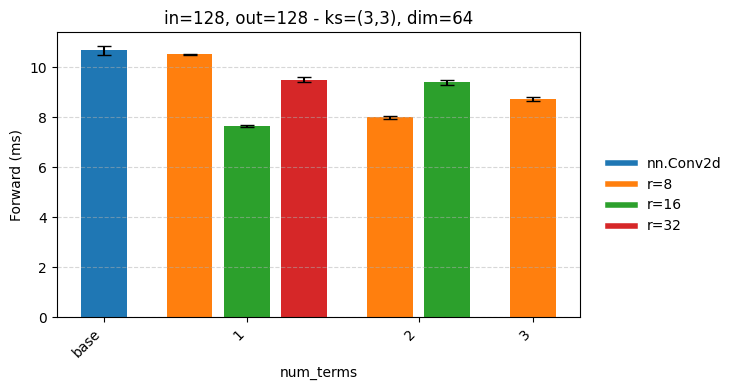

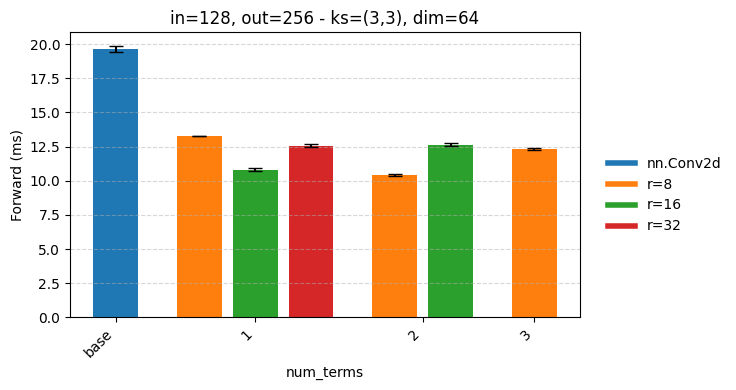

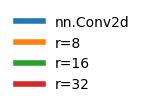

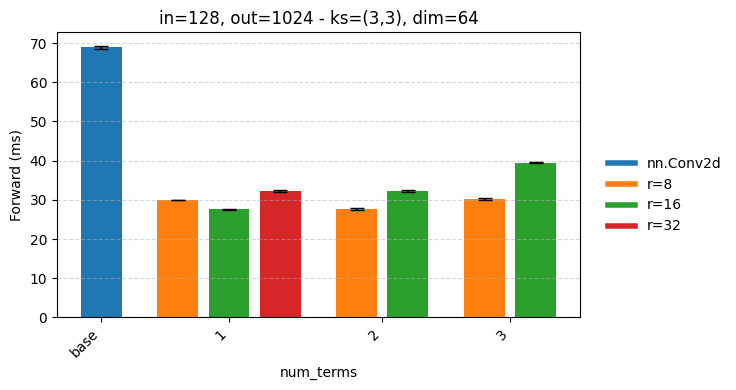

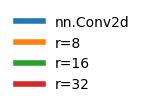

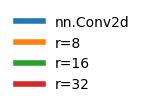

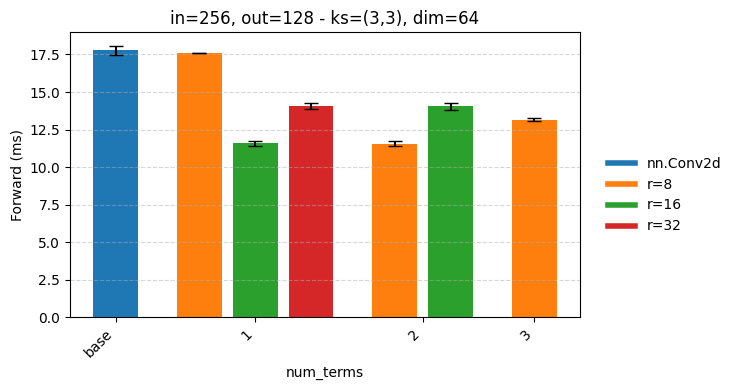

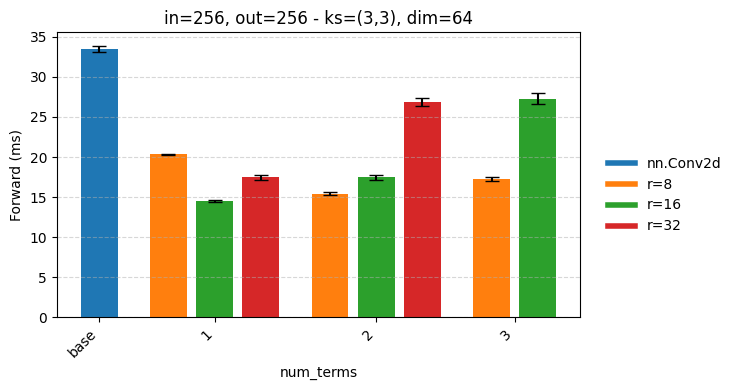

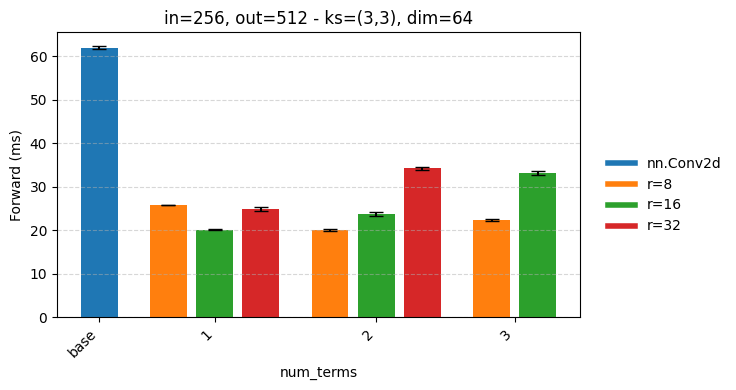

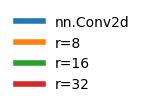

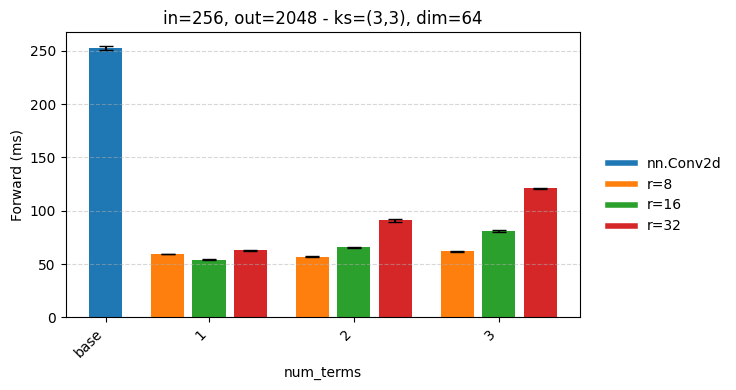

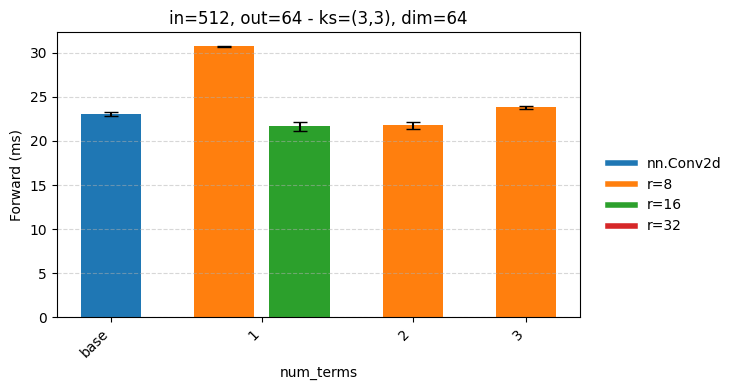

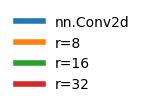

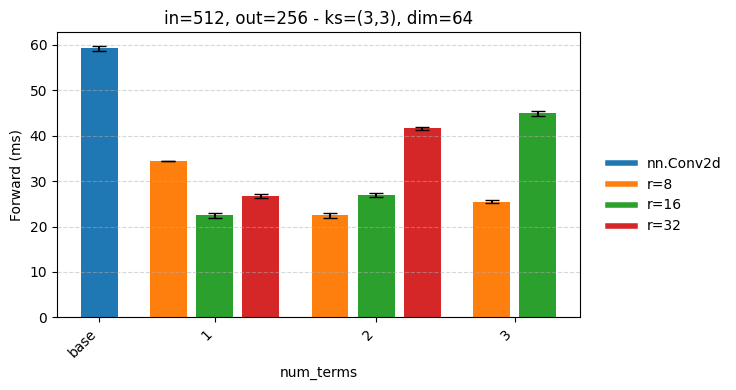

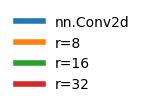

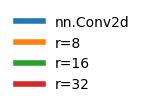

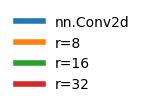

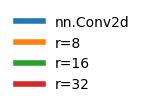

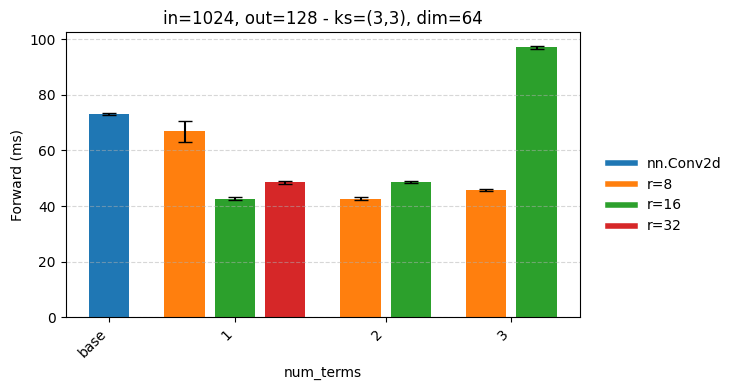

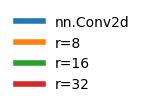

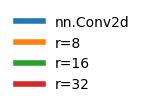

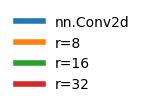

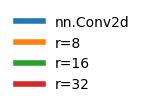

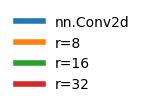

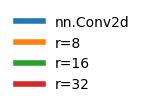

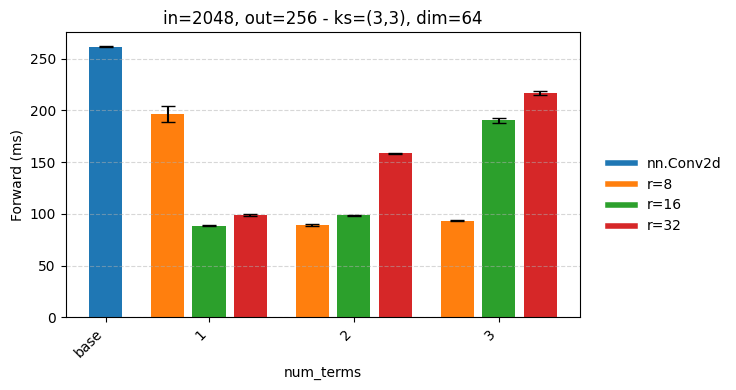

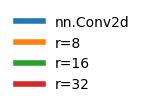

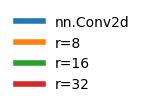

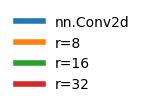

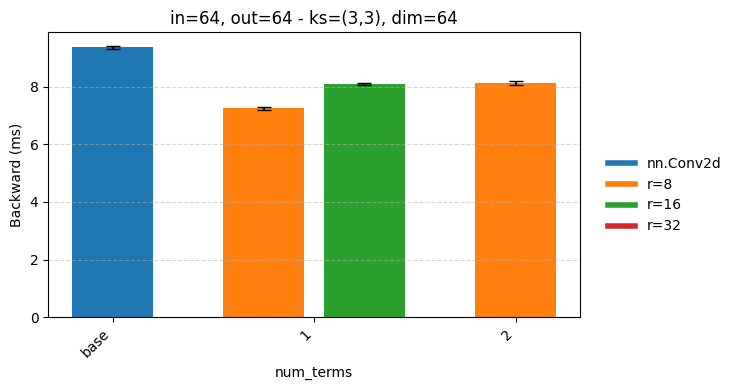

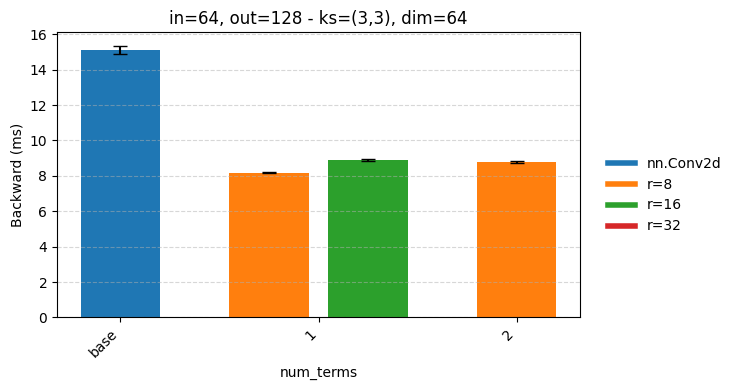

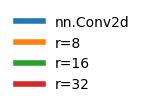

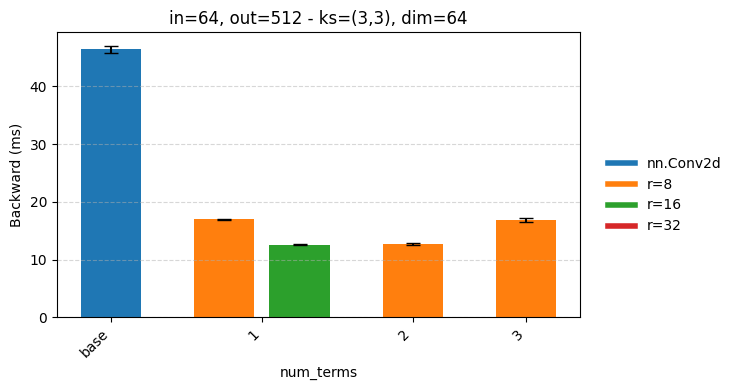

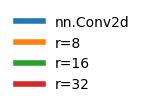

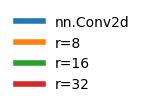

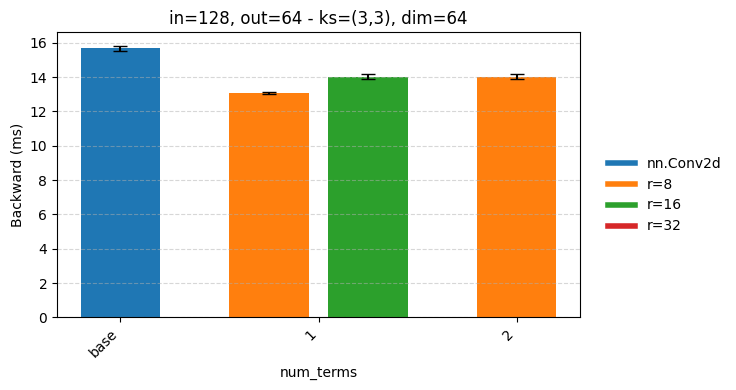

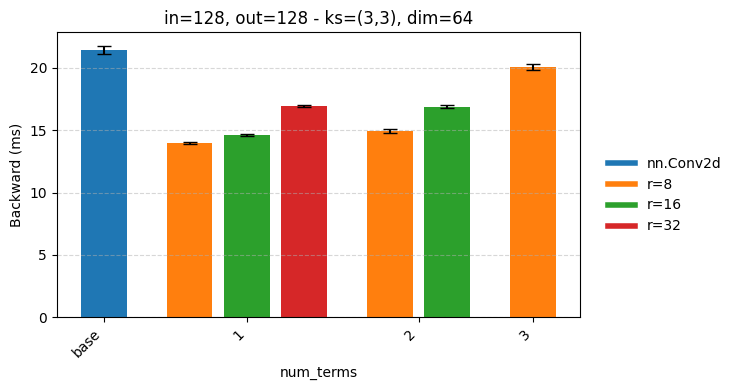

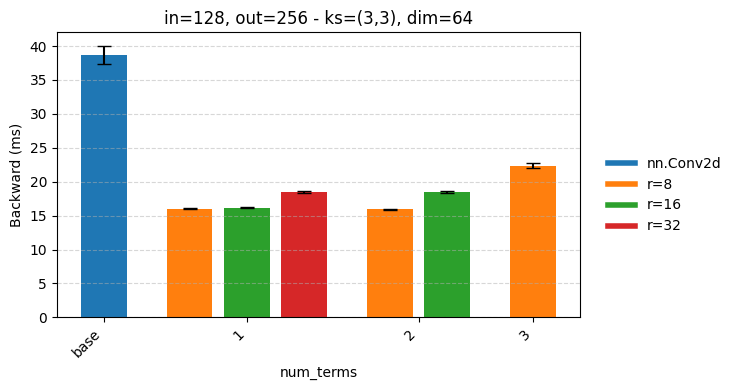

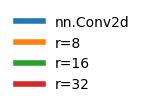

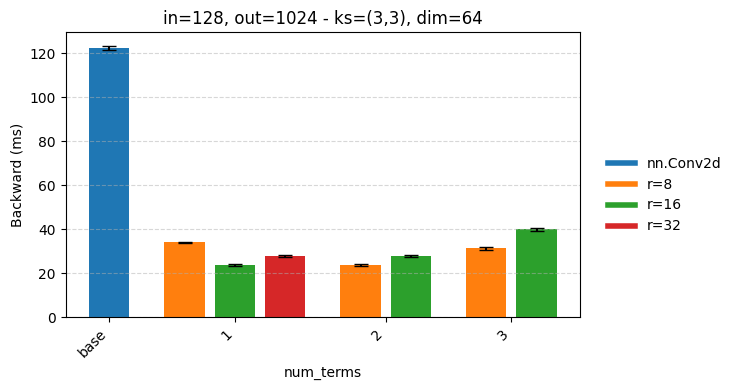

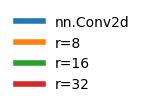

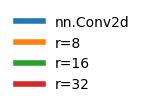

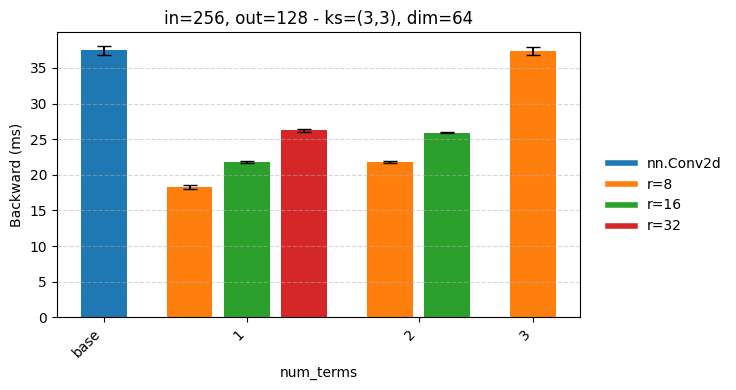

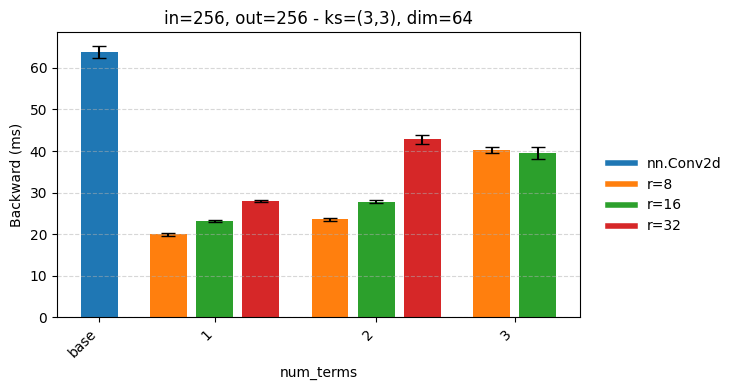

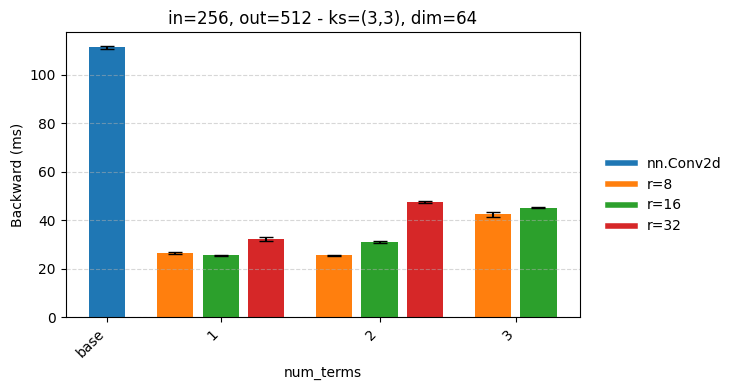

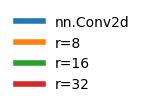

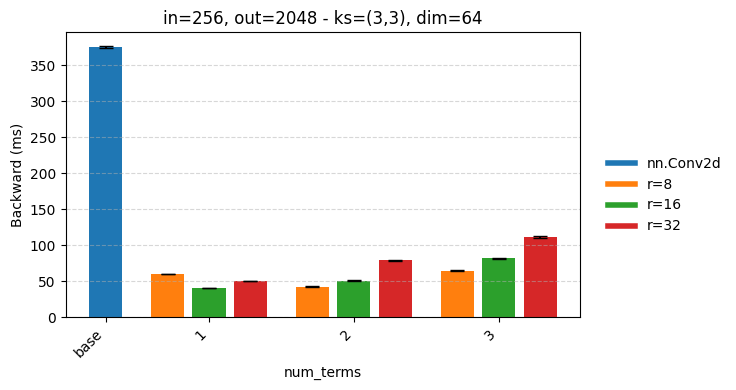

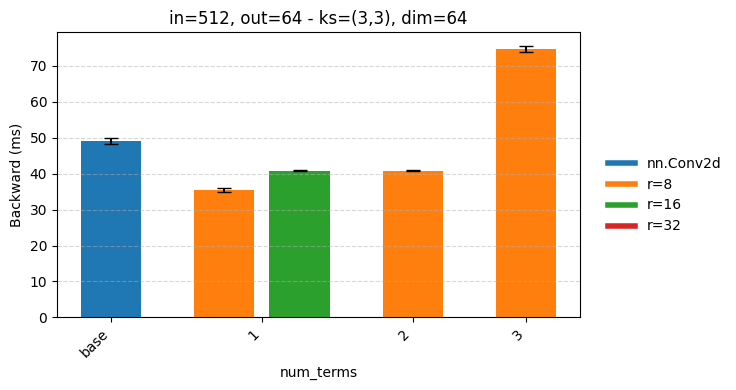

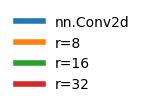

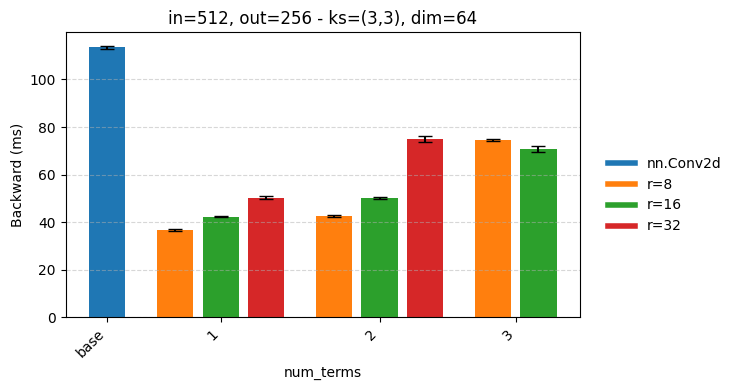

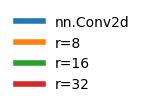

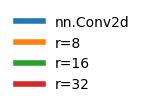

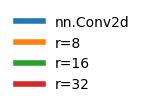

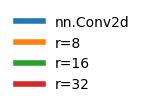

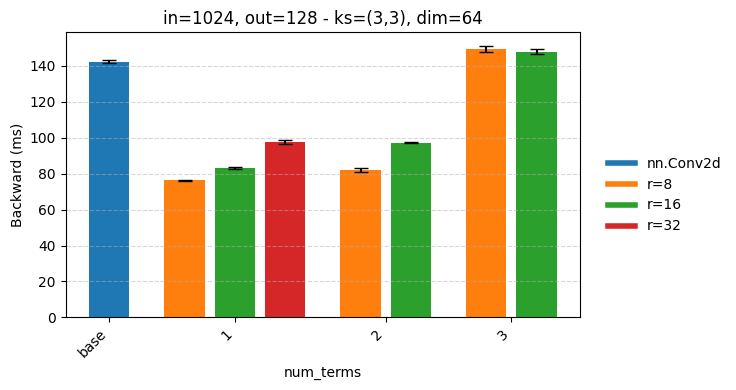

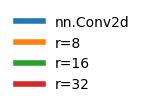

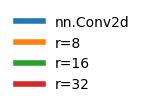

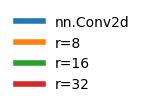

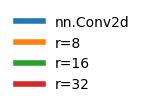

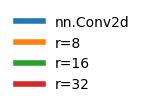

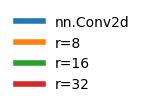

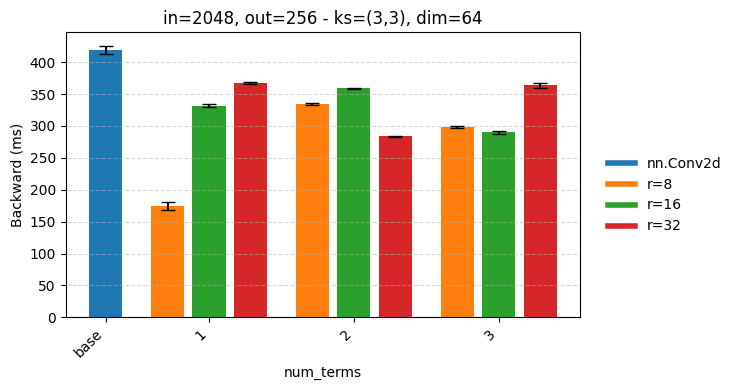

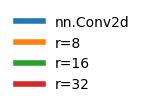

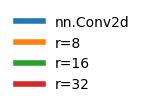

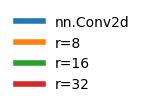

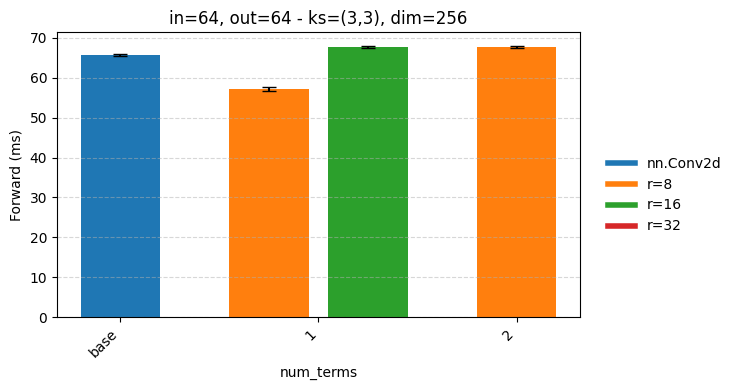

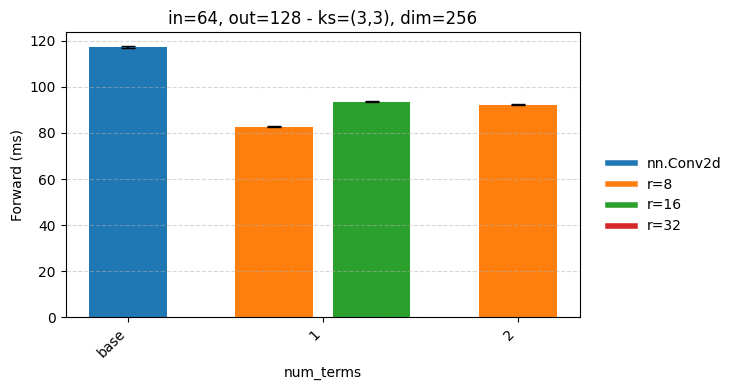

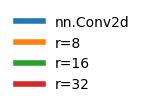

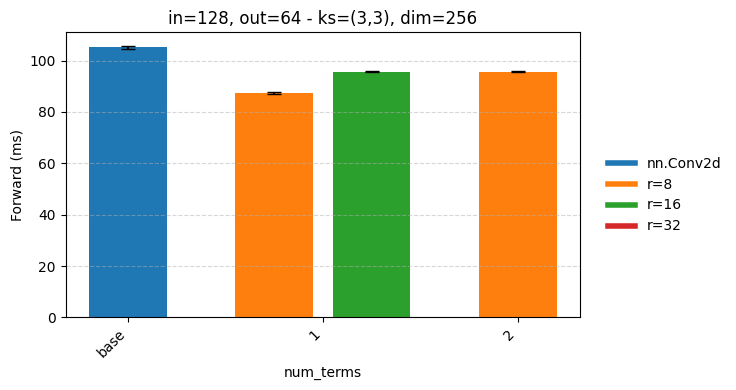

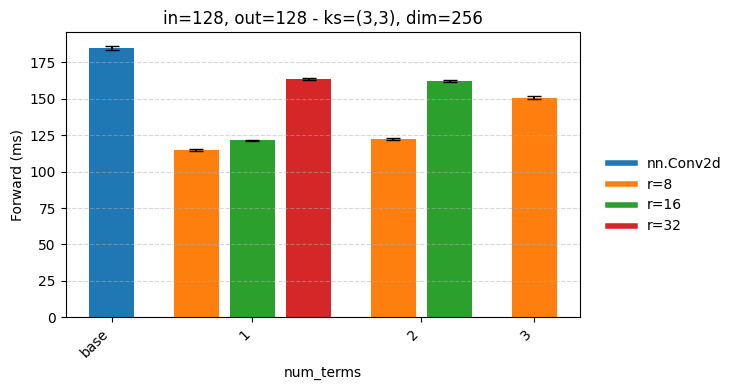

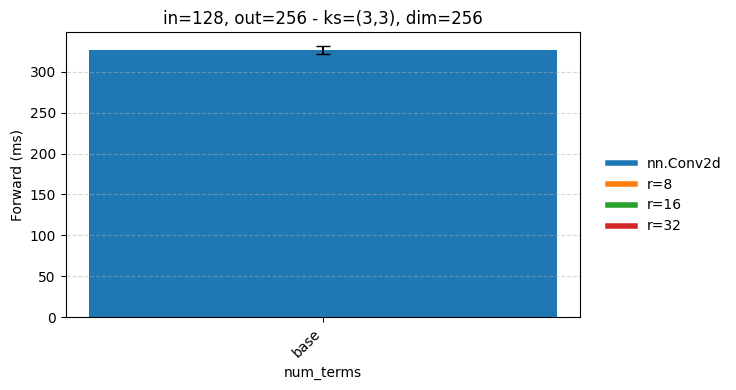

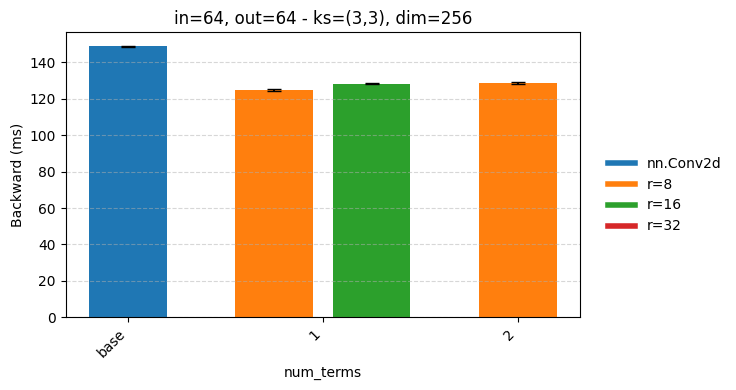

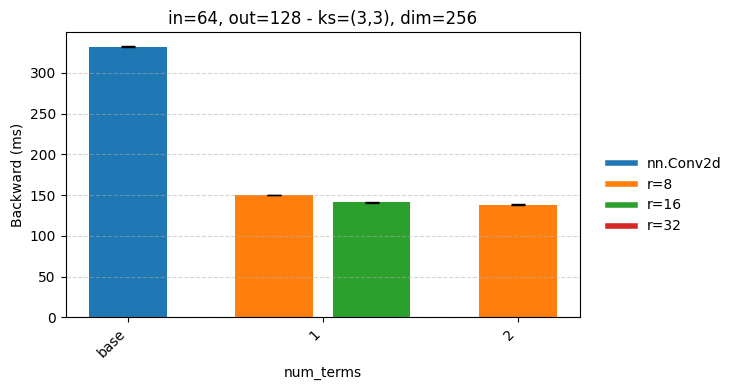

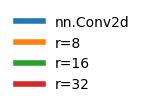

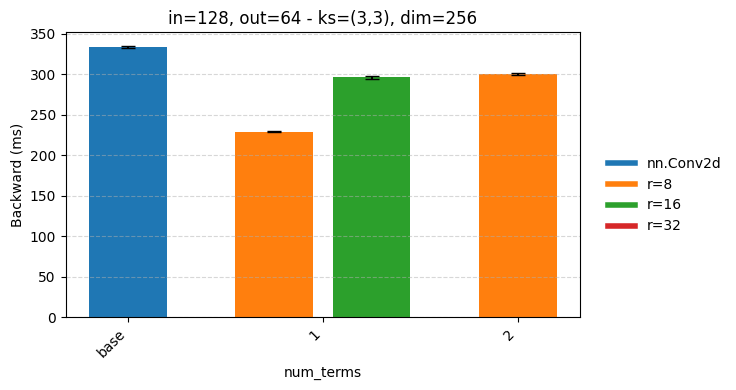

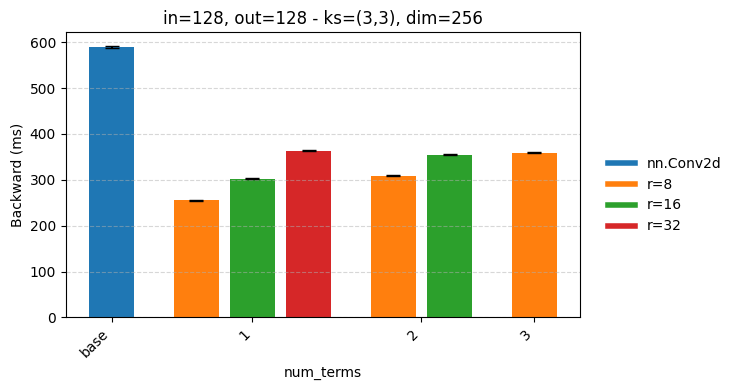

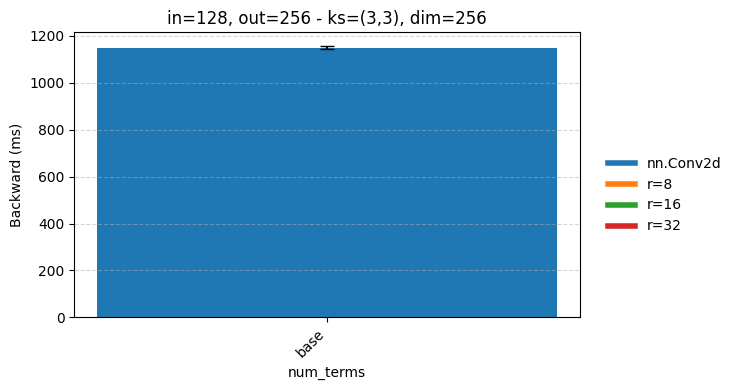

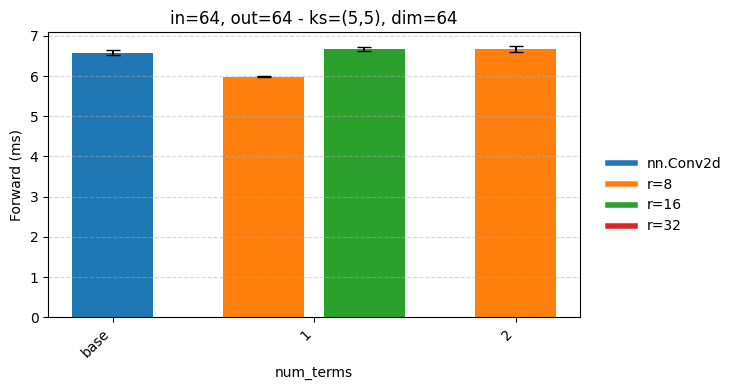

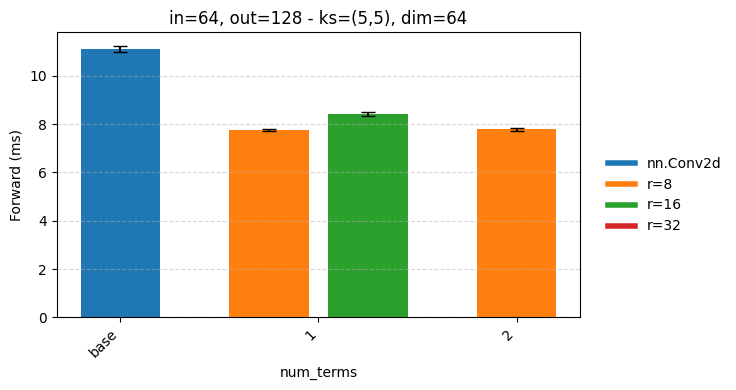

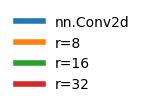

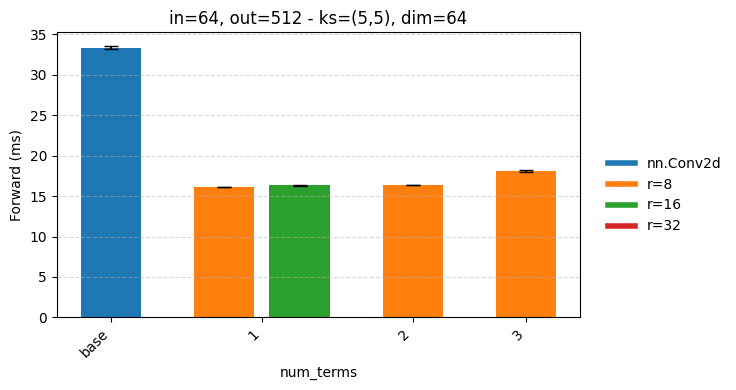

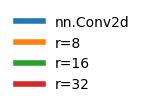

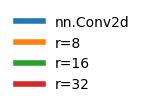

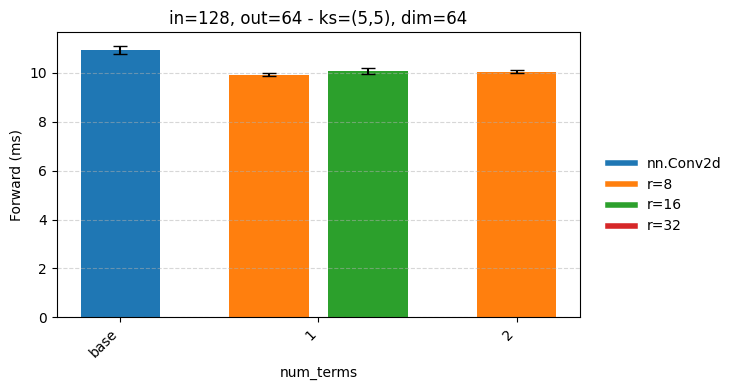

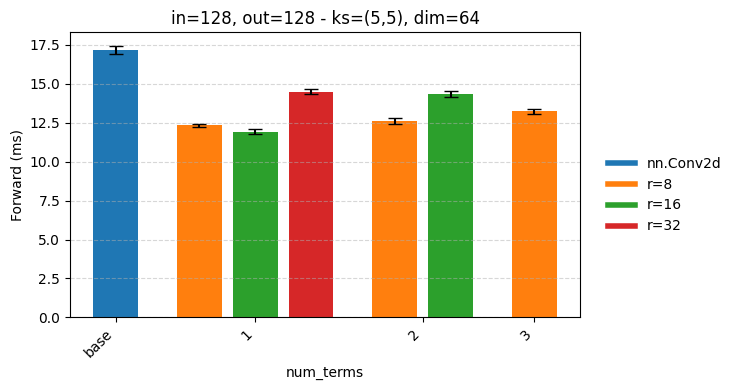

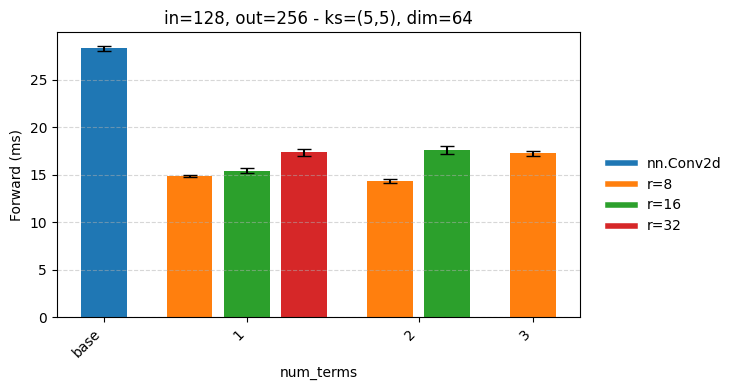

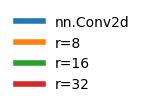

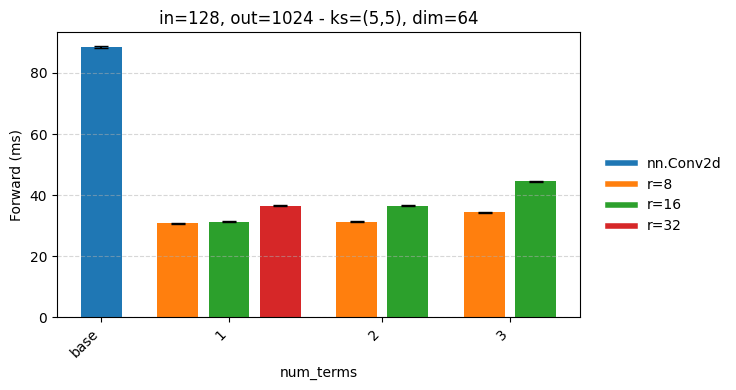

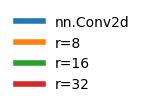

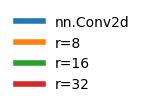

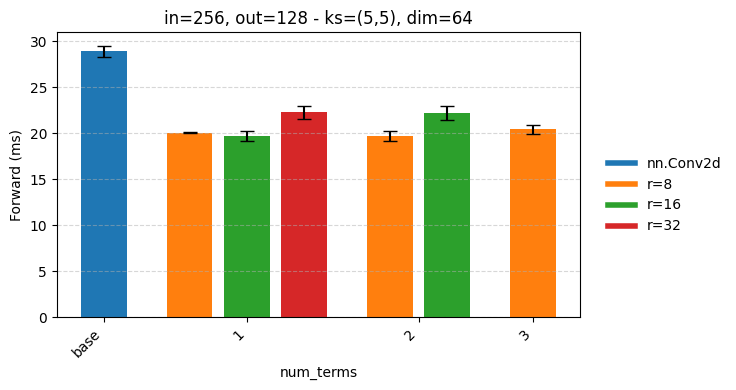

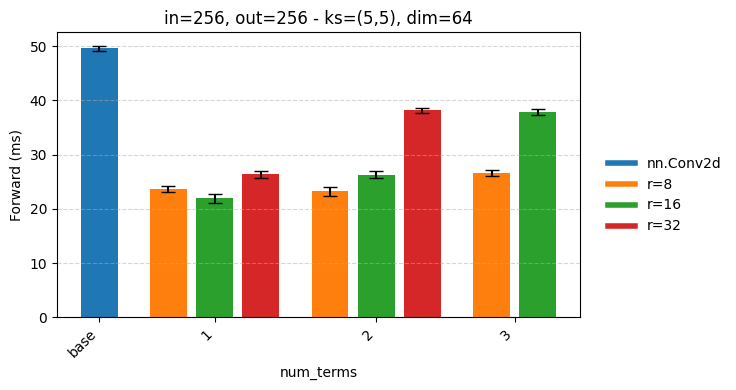

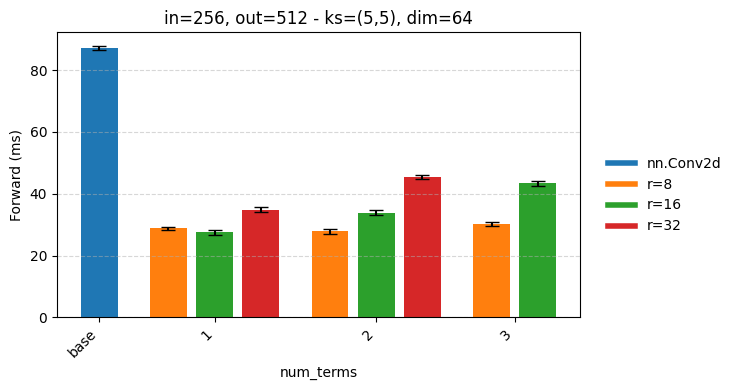

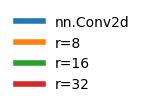

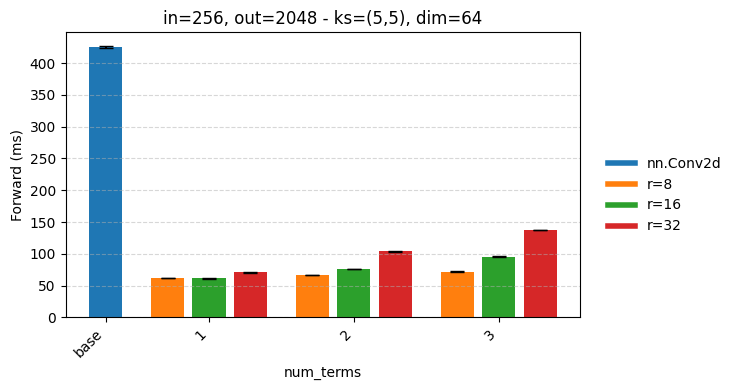

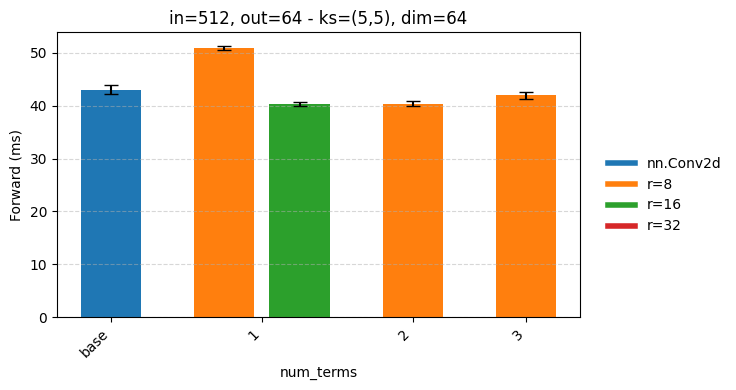

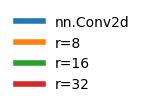

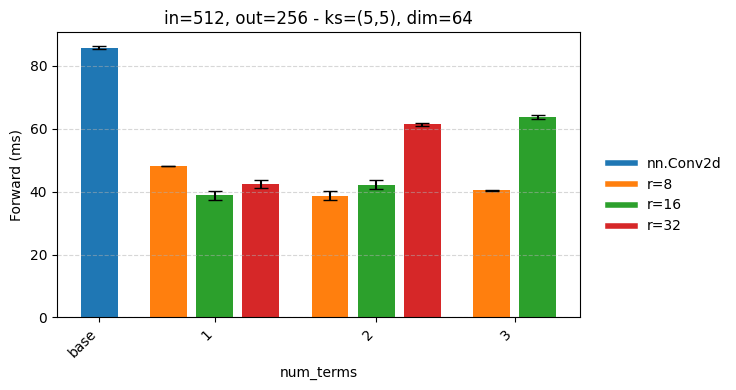

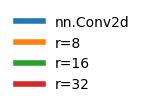

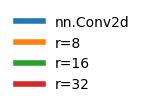

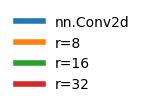

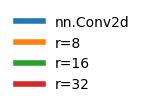

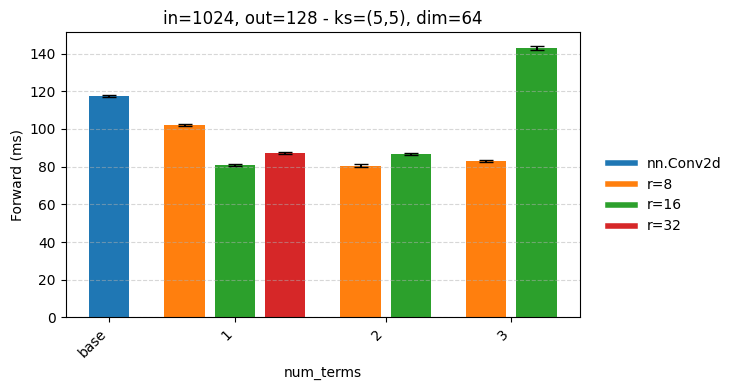

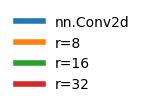

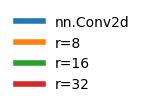

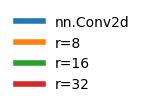

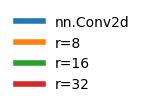

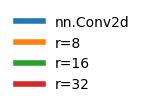

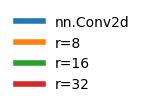

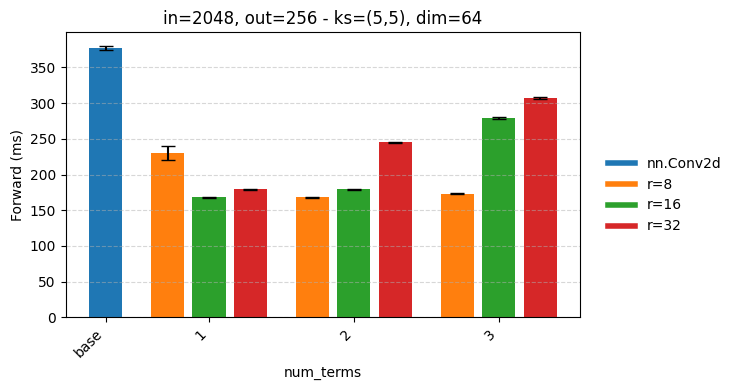

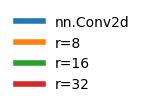

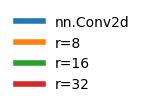

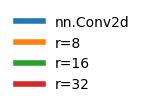

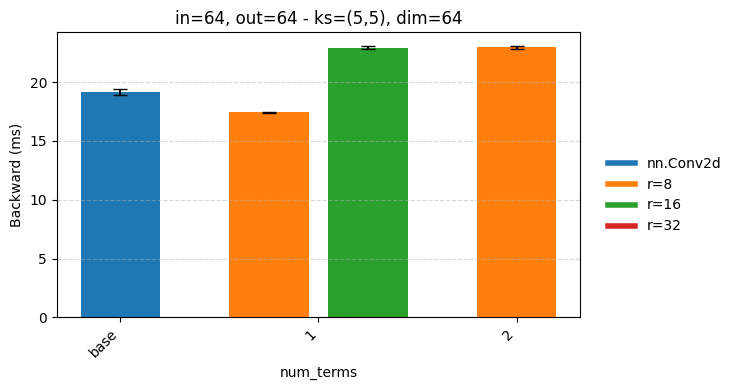

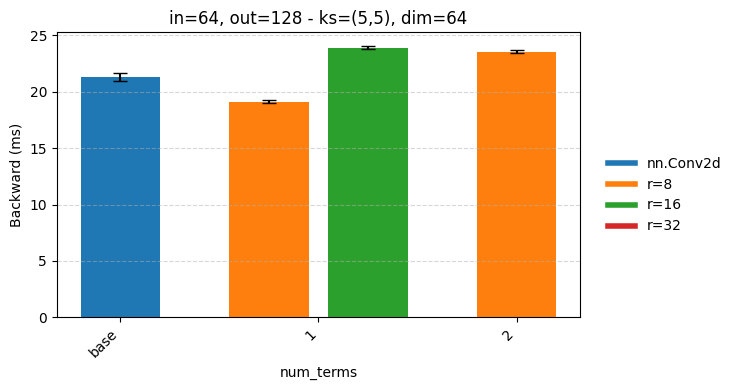

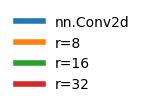

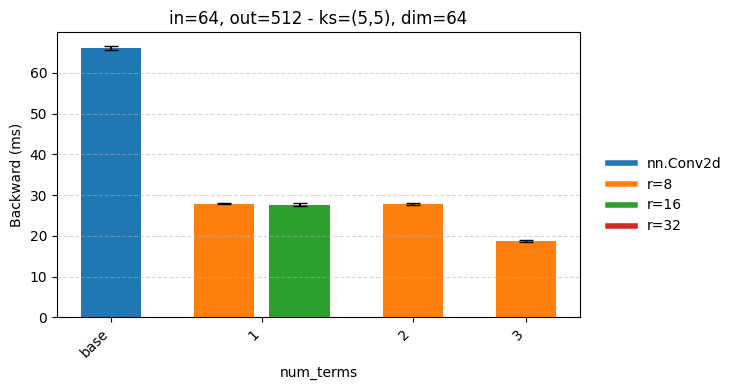

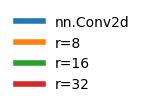

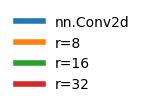

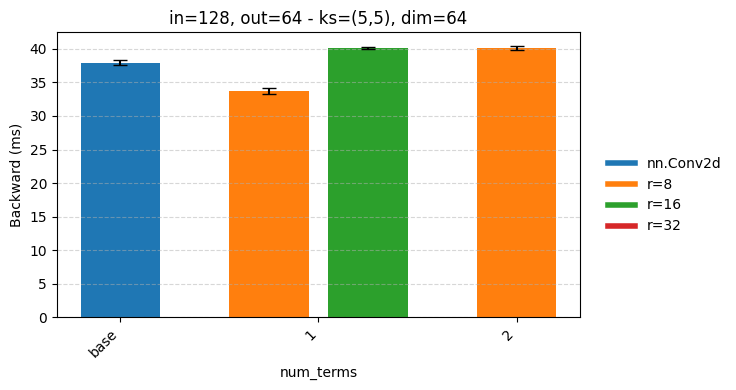

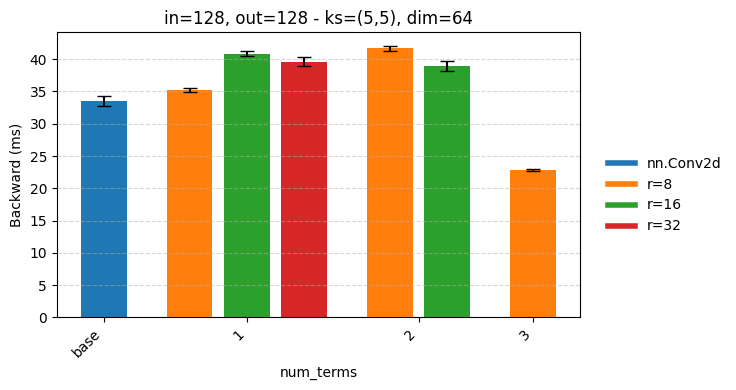

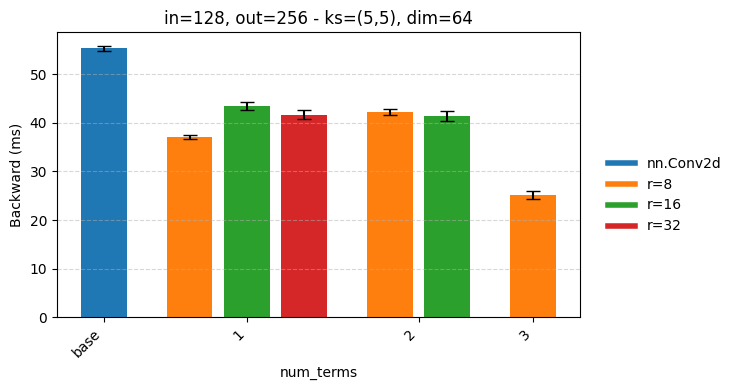

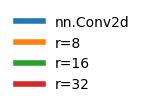

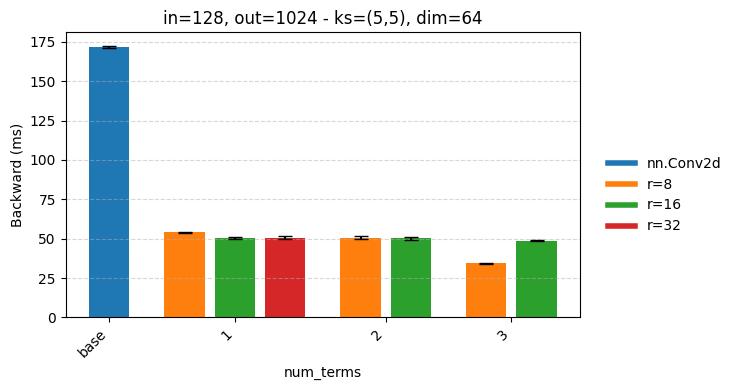

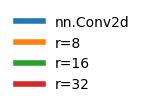

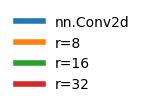

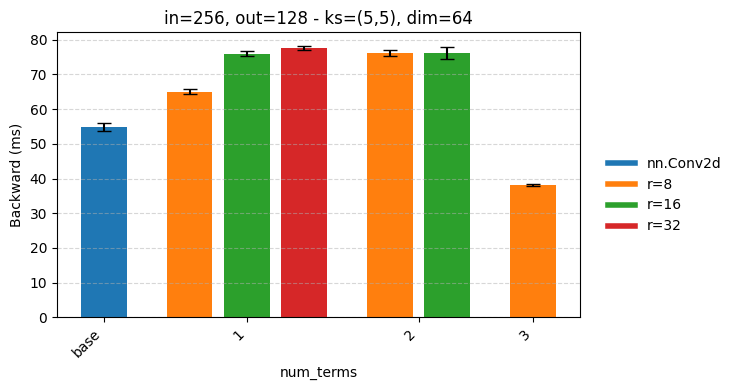

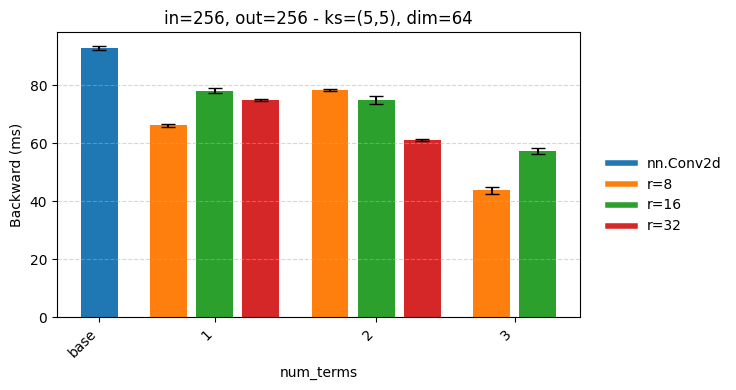

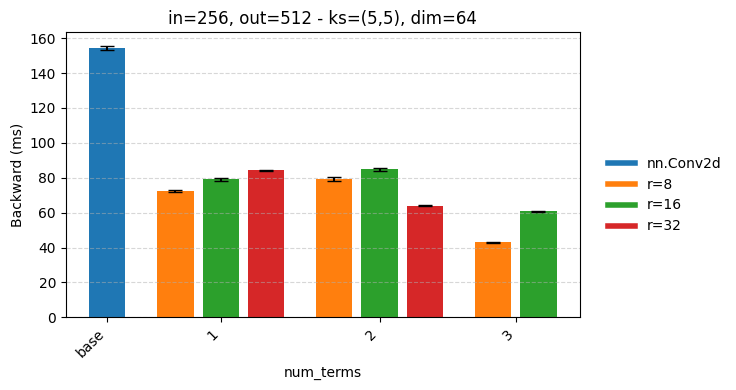

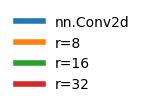

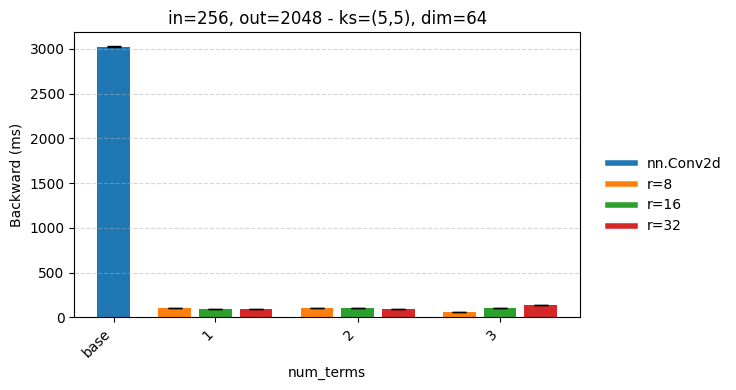

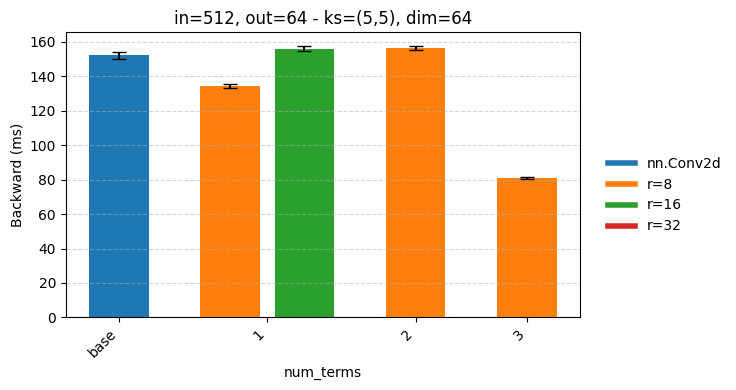

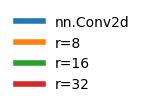

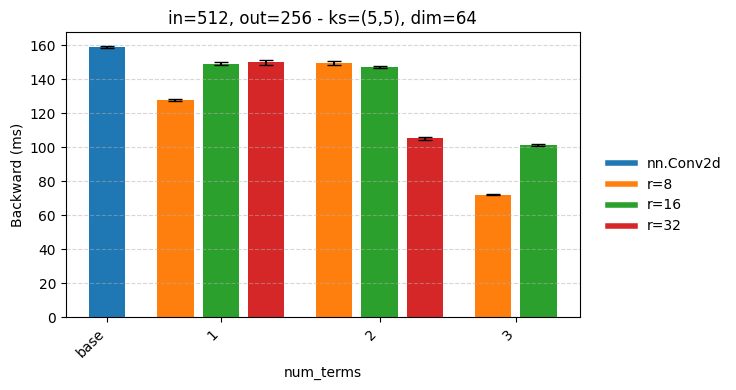

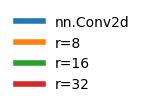

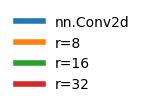

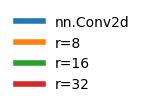

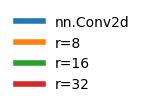

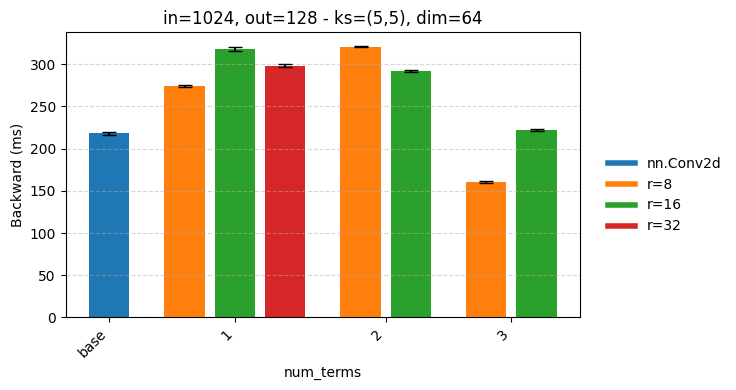

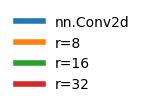

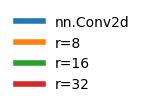

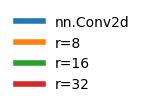

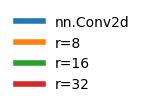

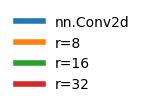

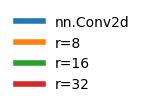

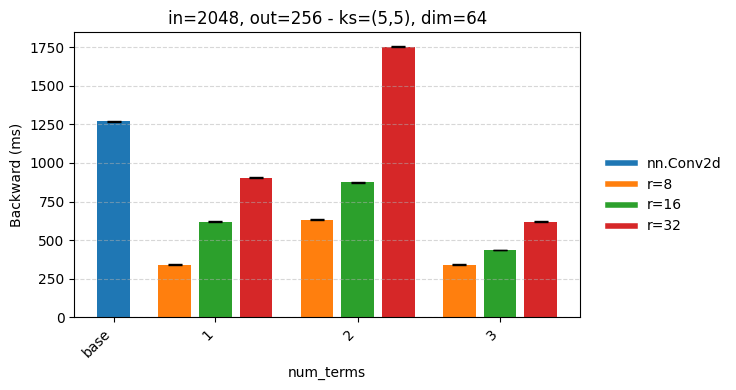

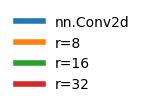

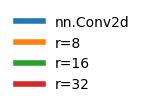

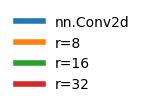

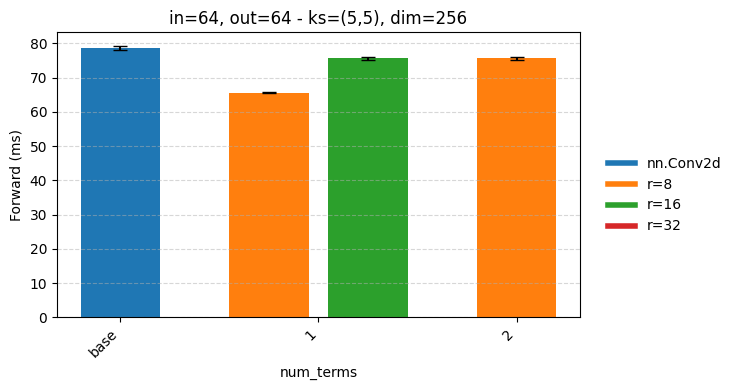

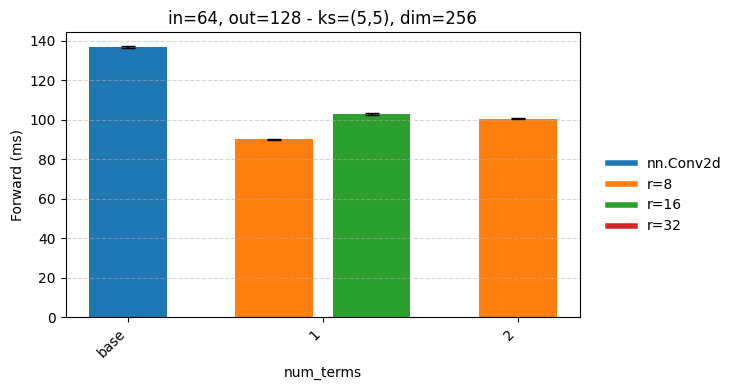

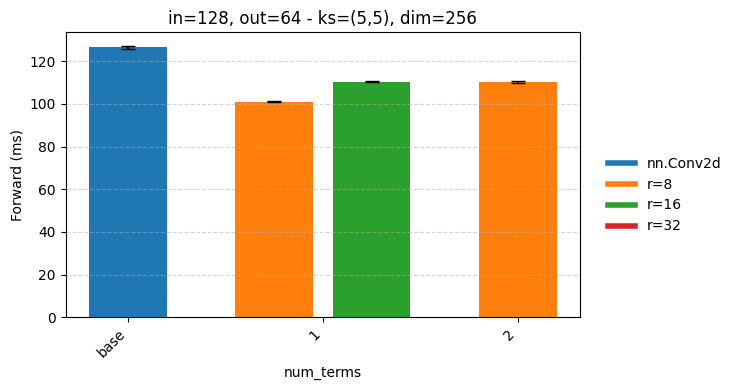

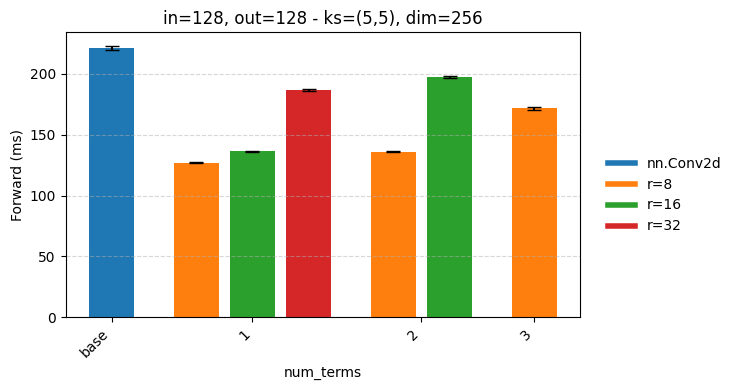

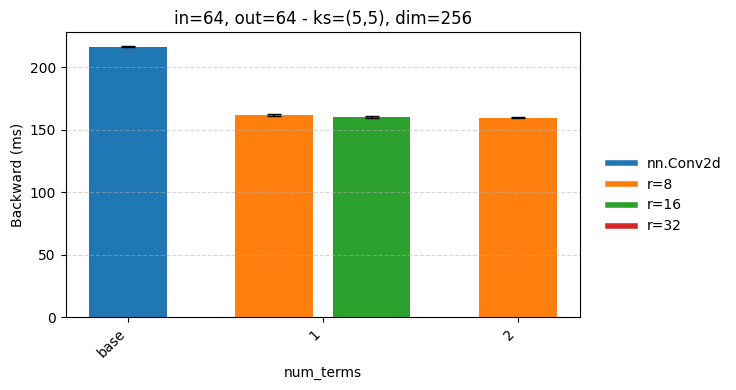

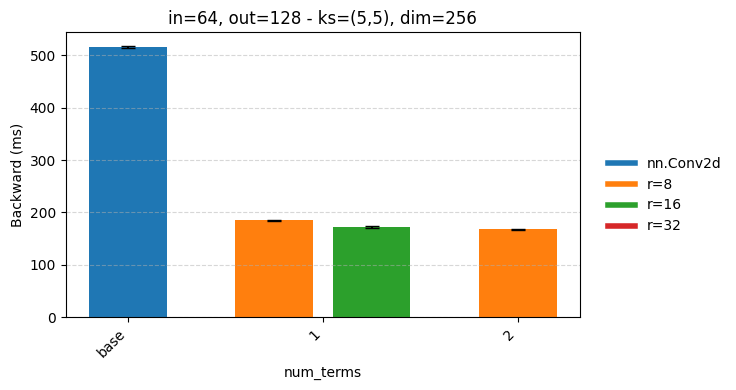

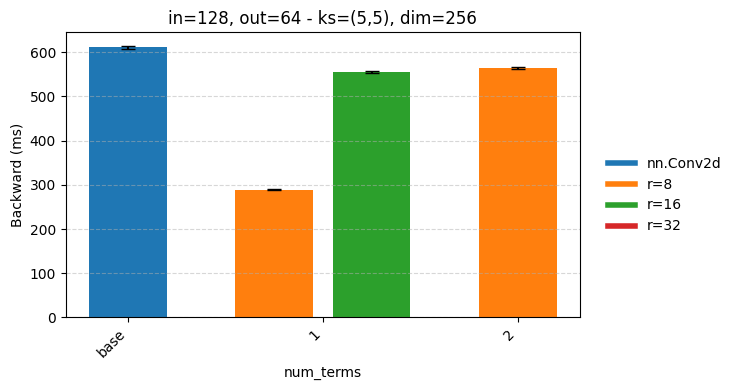

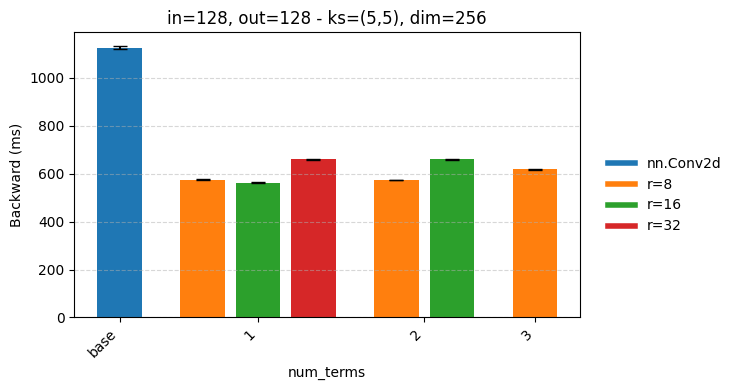

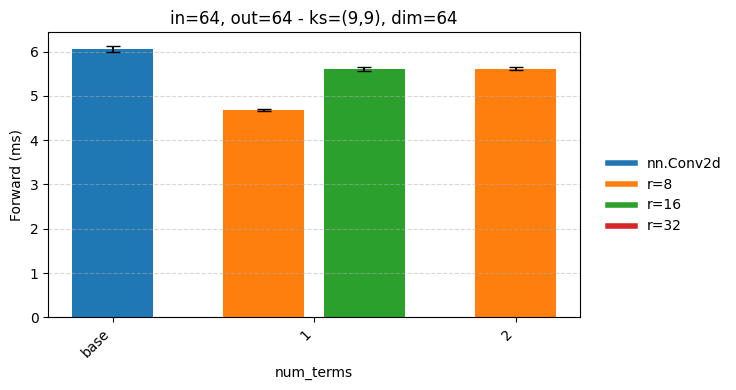

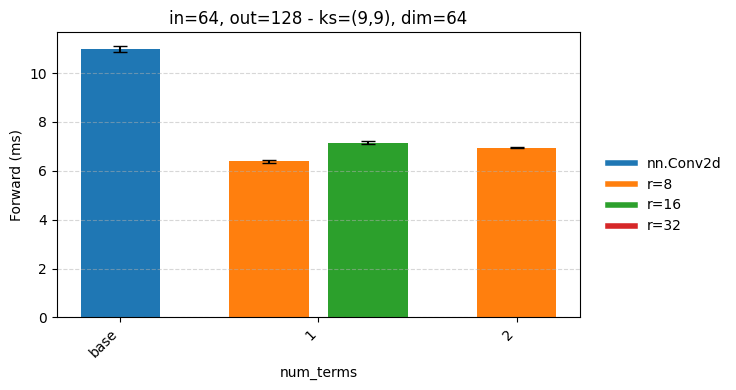

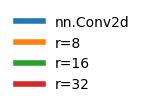

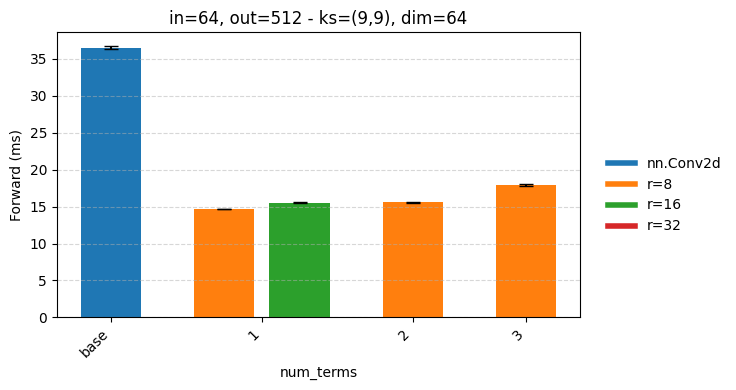

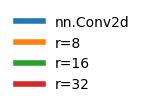

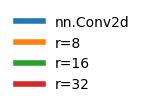

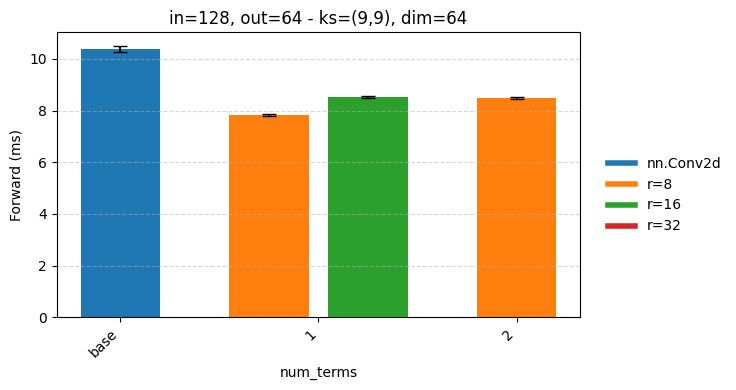

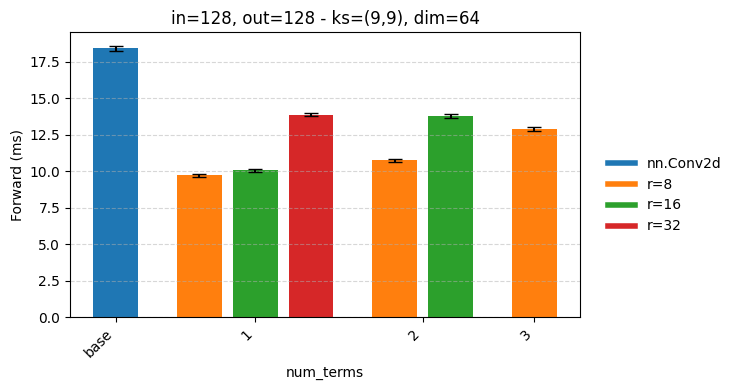

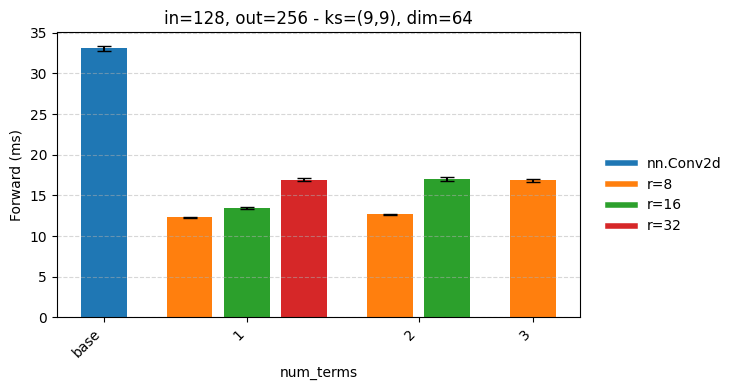

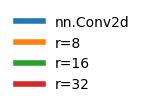

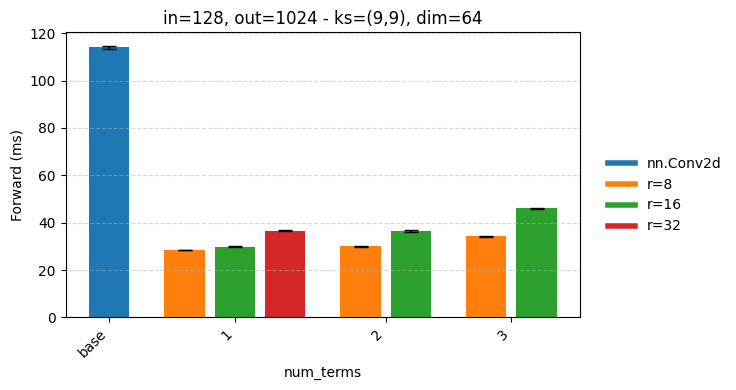

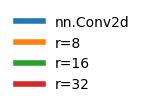

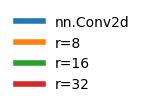

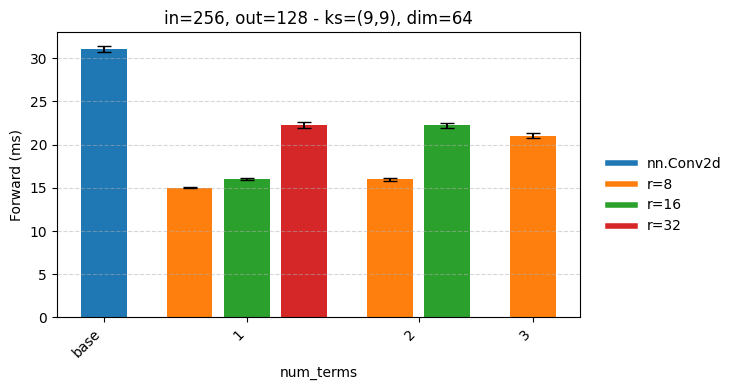

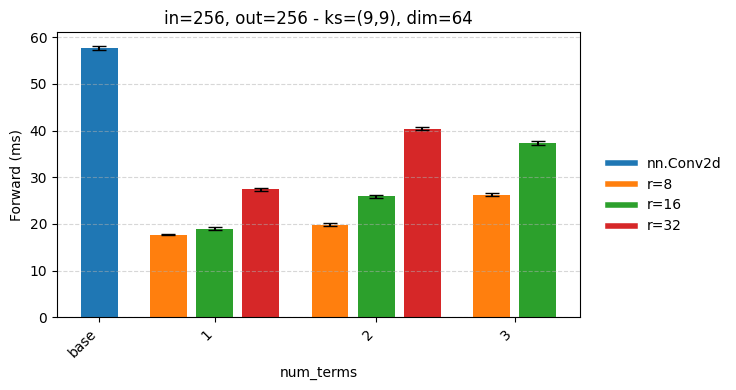

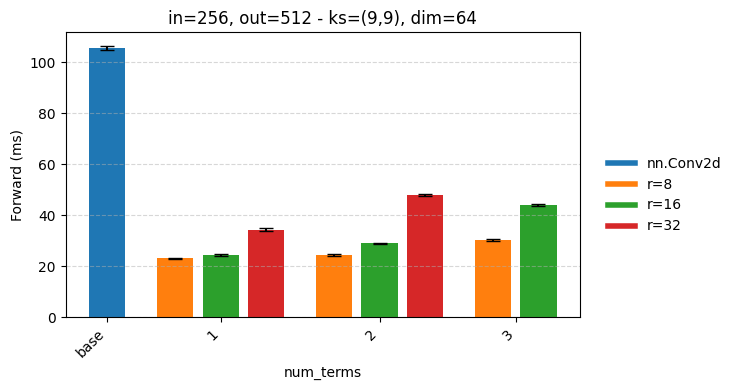

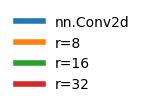

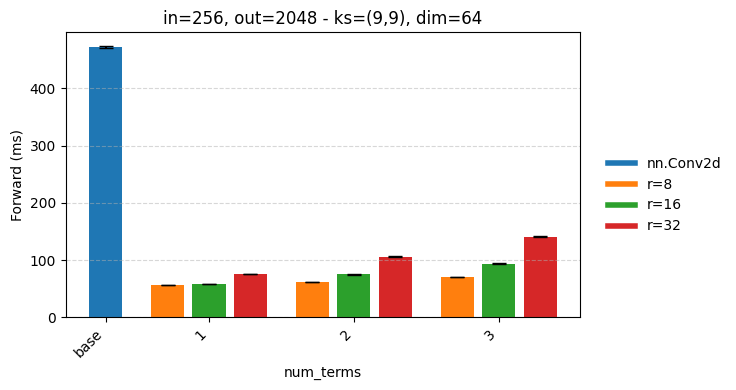

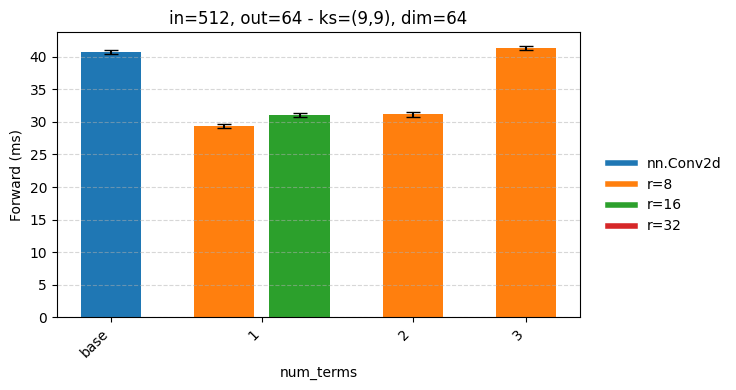

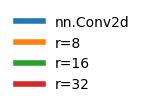

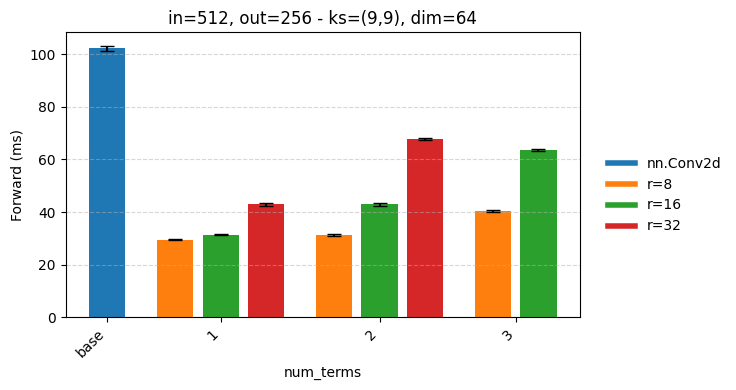

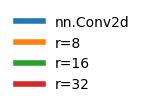

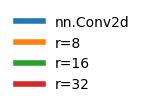

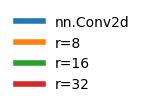

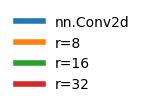

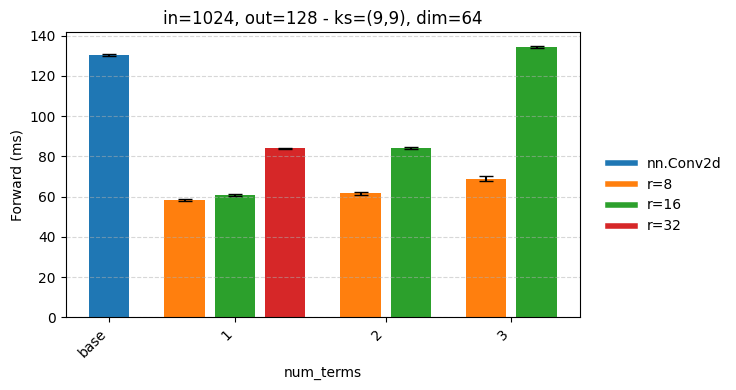

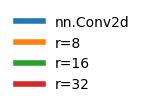

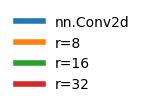

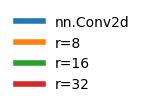

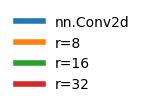

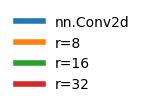

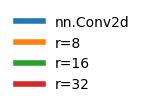

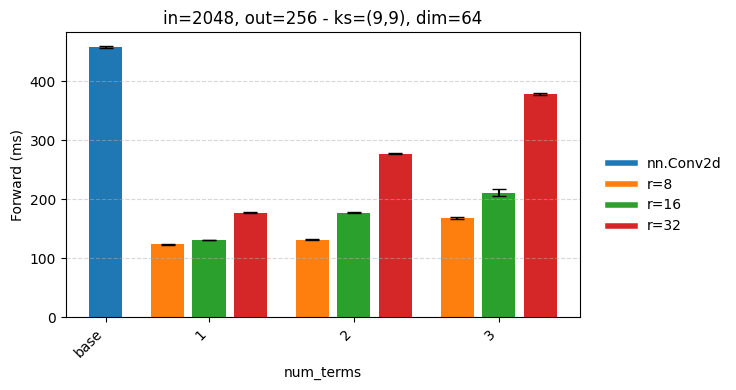

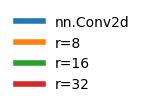

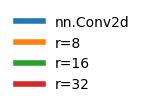

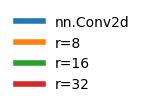

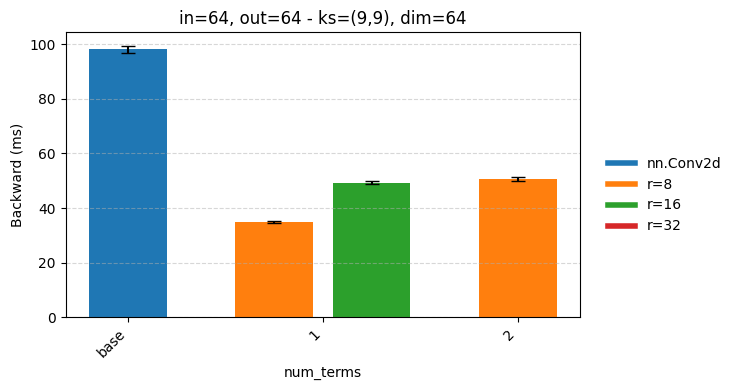

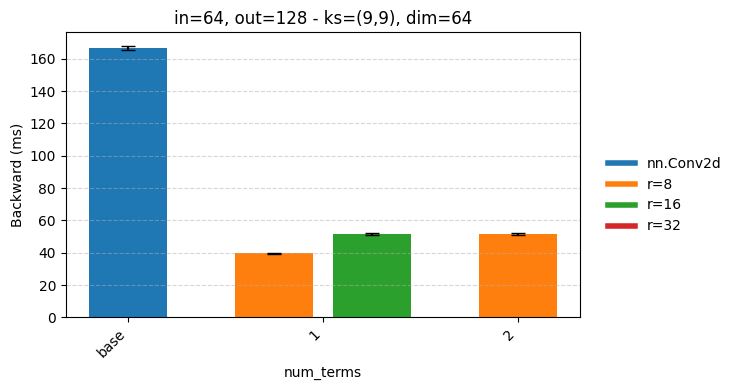

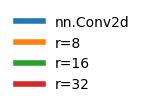

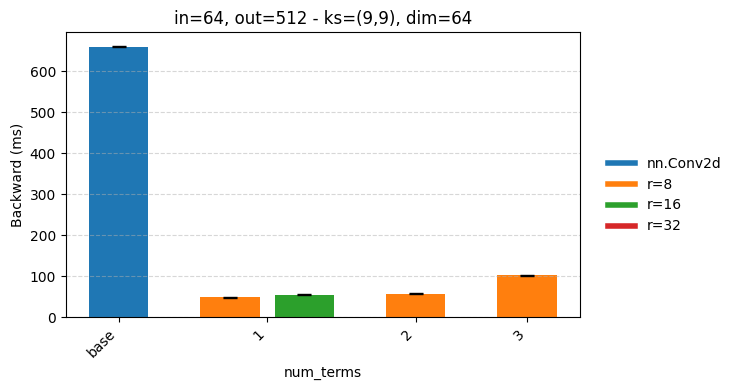

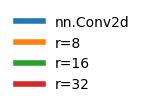

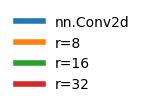

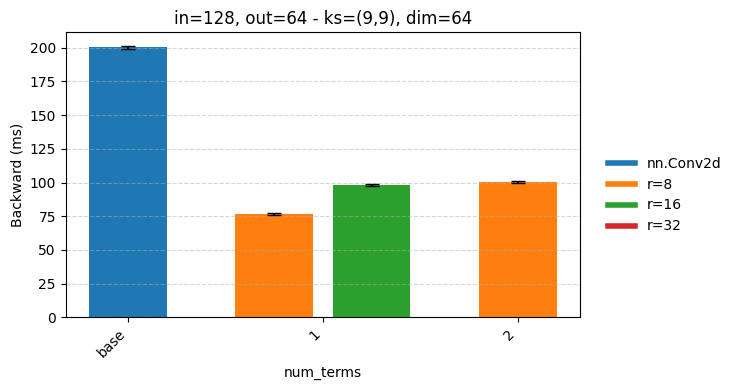

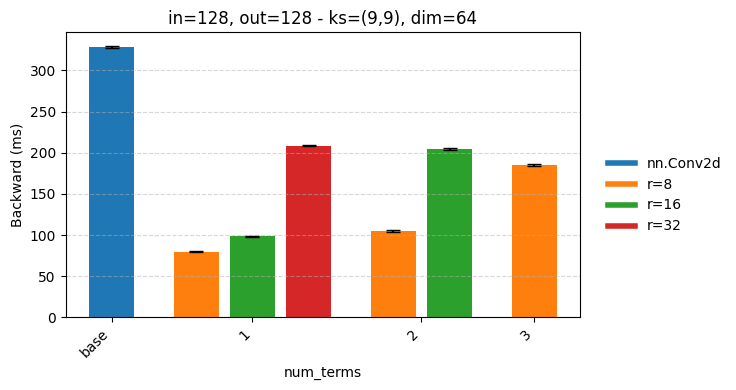

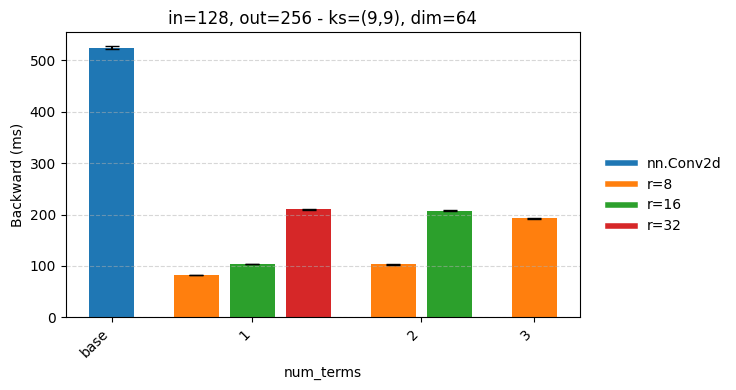

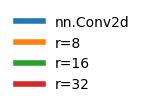

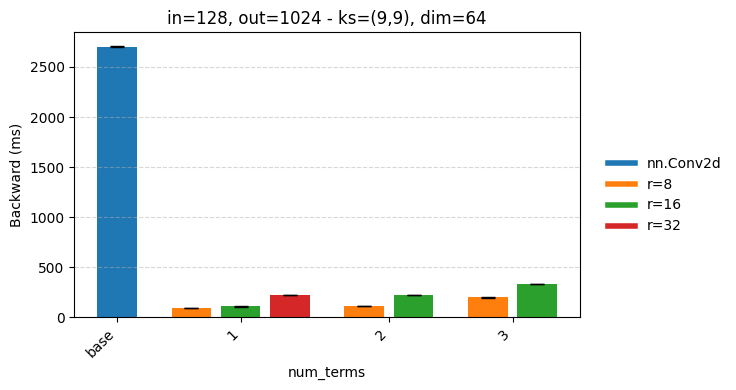

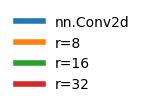

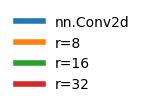

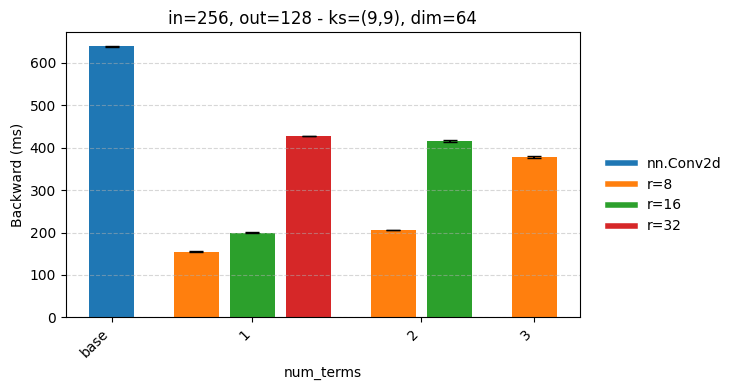

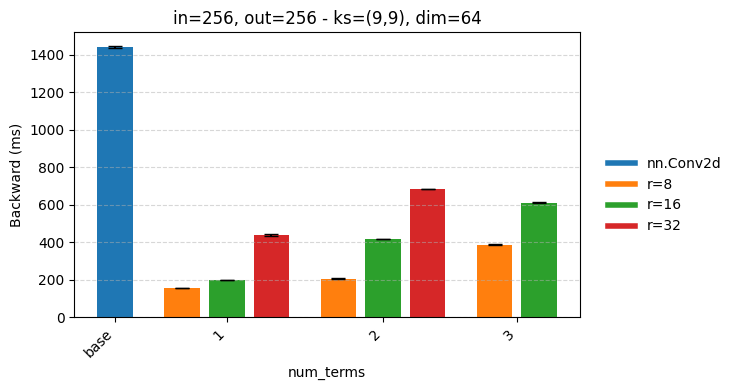

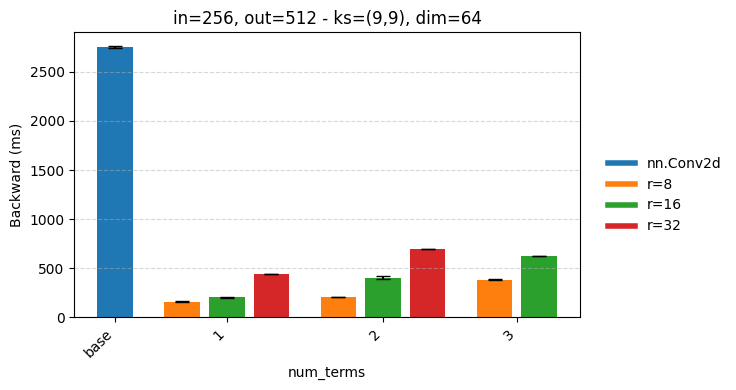

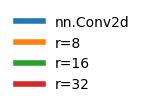

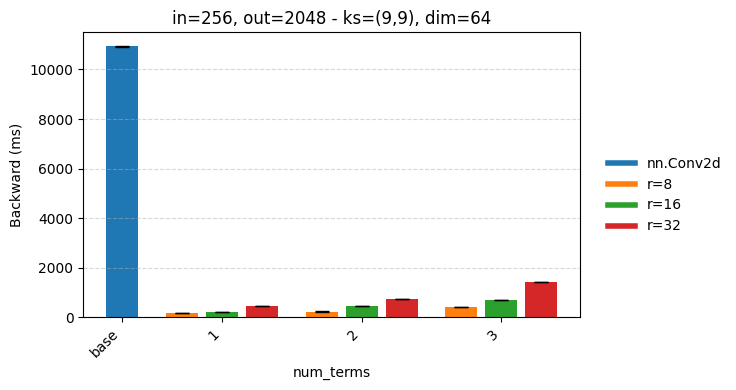

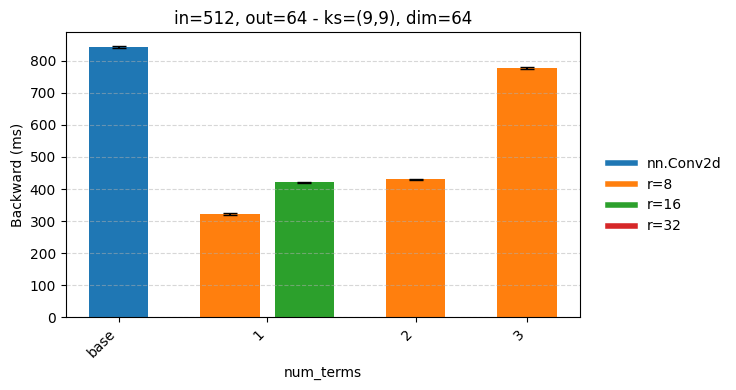

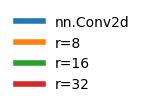

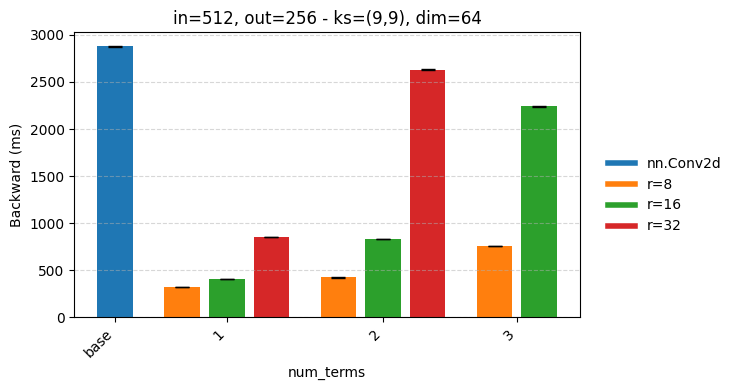

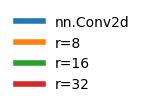

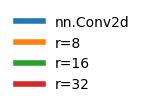

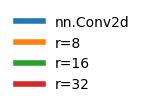

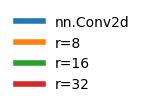

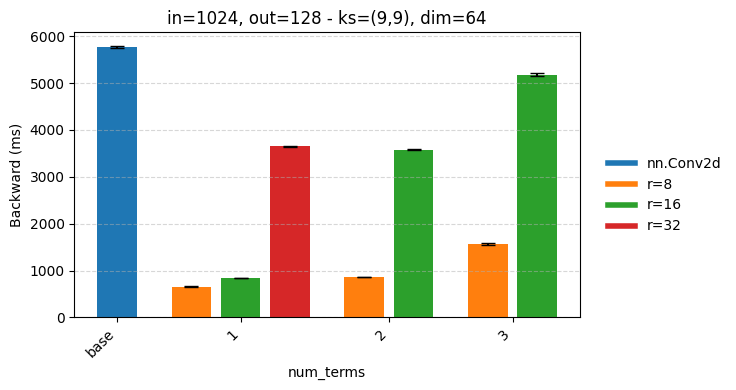

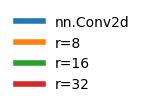

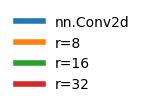

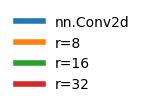

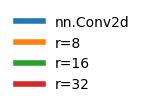

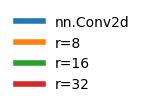

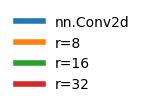

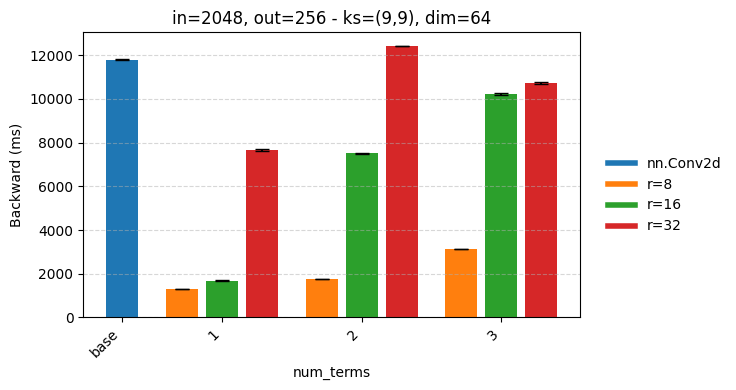

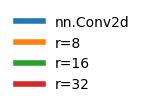

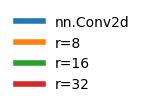

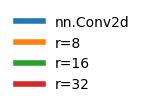

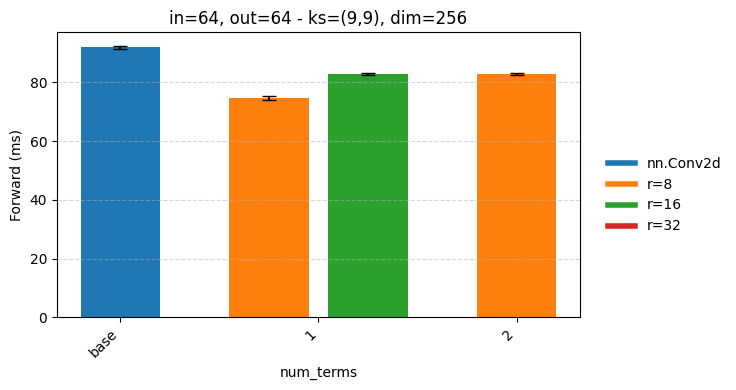

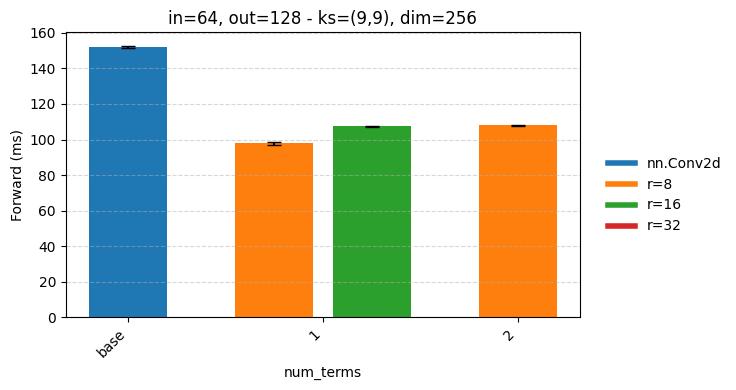

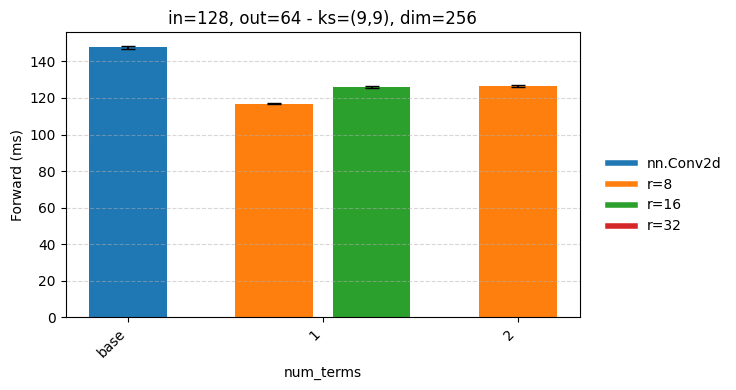

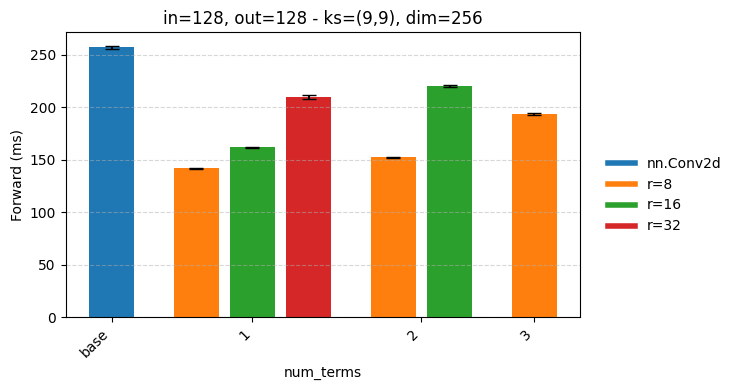

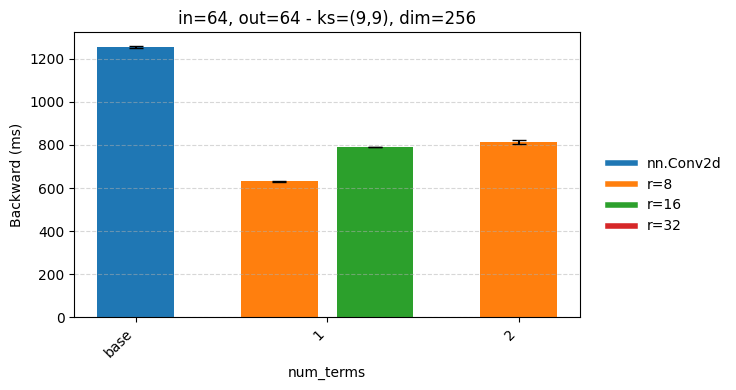

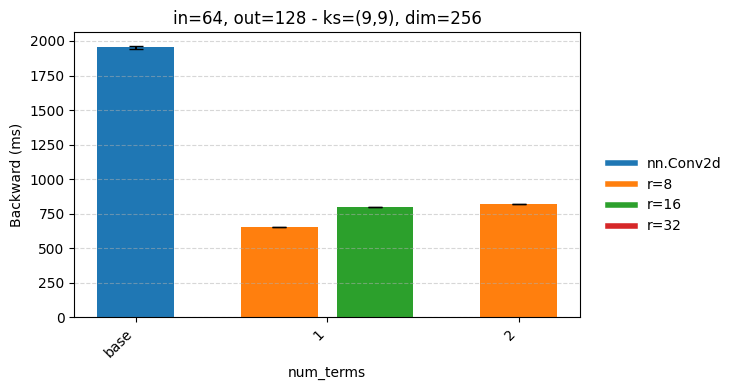

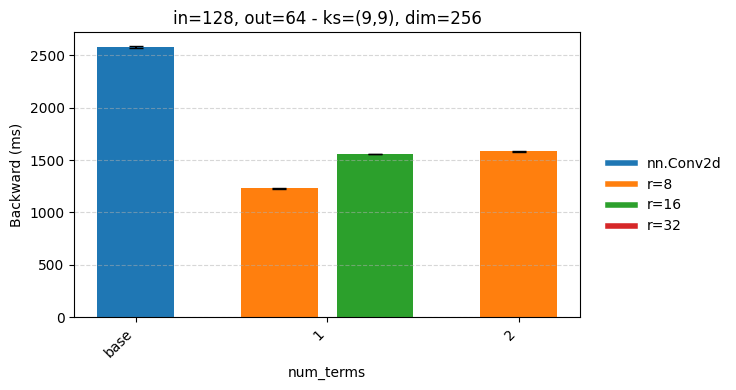

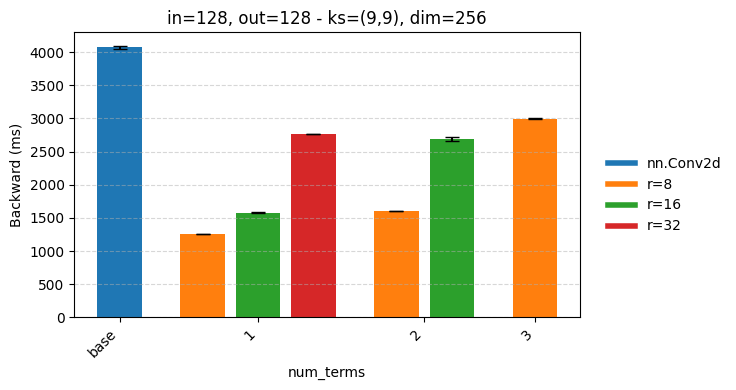

In [3]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

# === Configuration ===
CSV_FILE = "results_conv.csv"  # Path to the combined CSV file
BASE_MODEL = "nn.Conv2d"  # model name to treat as baseline
METRICS = [
    ("forward_mean_ms", "forward_std_ms", "Forward"),
    ("backward_mean_ms", "backward_std_ms", "Backward"),
]

# Plot mode toggles
USE_GRID = False  # True: grid layout; False: standalone plots
ALL_IN_ONE = False  # If True and USE_GRID, puts entire grid into one figure

# Legend configuration
LEGEND_NCOL = 1
LEGEND_LOC = "center left"
LEGEND_BBOX = (1.0, 0.5)
TIGHT_RECT = [0, 0, 1, 0.95]


# === Load and clean ===
def load_and_clean(csv_path):
    df = pd.read_csv(csv_path)
    # drop rows missing metrics
    df = df.dropna(subset=[m for m, s, _ in METRICS])
    return df


df = load_and_clean(CSV_FILE)

# Unique tweak combinations (excluding baseline)
tweaks = (
    df[df["model"] != BASE_MODEL][["num_terms", "low_rank"]]
    .drop_duplicates()
    .sort_values(["num_terms", "low_rank"])  # sorted by num_terms then low_rank
    .values.tolist()
)
unique_lrs = sorted({lr for nt, lr in tweaks})

# Color mapping
cmap = get_cmap("tab10")
grid_colors = {lr: cmap(i + 1) for i, lr in enumerate(unique_lrs)}
base_color = cmap(0)


# Helper to get mean and std
def get_stats(subdf, metric_mean, metric_std, in_c, out_c, ks, dim, nt=None, lr=None):
    sub = subdf.copy()
    # filter keys
    sub = sub[
        (sub["in_channels"] == in_c)
        & (sub["out_channels"] == out_c)
        & (sub["kernel_size"] == ks)
        & (sub["dimension"] == dim)
    ]
    if nt is not None and lr is not None:
        sub = sub[(sub["num_terms"] == nt) & (sub["low_rank"] == lr)]
    if sub.empty:
        return None, None
    return sub[metric_mean].mean(), sub[metric_std].mean()


# Plot a block of subplots for one metric


def plot_block(fig, axes, metric_mean, metric_std, title, pairs, group_df):
    # metric_mean: e.g. 'forward_mean_ms', metric_std similarly
    for ax, (in_c, out_c) in zip(axes.flat, pairs):
        labels, heights, errs, colors = [], [], [], []

        # baseline
        m_base, s_base = get_stats(
            group_df[group_df["model"] == BASE_MODEL],
            metric_mean,
            metric_std,
            in_c,
            out_c,
            group_df["kernel_size"].iloc[0],
            group_df["dimension"].iloc[0],
        )
        if m_base is not None:
            labels.append("base")
            heights.append(m_base)
            errs.append(s_base)
            colors.append(base_color)

        # variants
        for nt, lr in tweaks:
            m_var, s_var = get_stats(
                group_df[group_df["model"] != BASE_MODEL],
                metric_mean,
                metric_std,
                in_c,
                out_c,
                group_df["kernel_size"].iloc[0],
                group_df["dimension"].iloc[0],
                nt,
                lr,
            )
            if m_var is None:
                continue
            labels.append(str(nt))
            heights.append(m_var)
            errs.append(s_var)
            colors.append(grid_colors[lr])

        if not heights:
            ax.set_visible(False)
            continue

        # x positions
        gap = 0.5
        x_positions, current = [], 0
        for idx, lab in enumerate(labels):
            x_positions.append(current)
            current += 1
            if idx + 1 == len(labels) or labels[idx + 1] != lab:
                current += gap
        x = np.array(x_positions)
        ax.bar(x, heights, color=colors, yerr=errs, capsize=5)

        # group ticks
        positions = OrderedDict()
        for xi, lab in zip(x_positions, labels):
            positions.setdefault(lab, []).append(xi)
        group_positions = [np.mean(xs) for xs in positions.values()]
        ax.set_xticks(group_positions)
        ax.set_xticklabels(positions.keys(), rotation=45, ha="right")
        ks = group_df["kernel_size"].iloc[0]
        dim = group_df["dimension"].iloc[0]
        ax.set_title(f"in={in_c}, out={out_c} - ks={ks}, dim={dim}")
        ax.set_xlabel("num_terms")
        ax.set_ylabel(f"{title} (ms)")
        ax.set_ylim(bottom=0)
        ax.grid(axis="y", linestyle="--", alpha=0.5)

    # legend
    legend_entries = [
        plt.Line2D([0], [0], color=base_color, lw=4, label=BASE_MODEL)
    ] + [
        plt.Line2D([0], [0], color=grid_colors[lr], lw=4, label=f"r={lr}")
        for lr in unique_lrs
    ]
    fig.legend(
        handles=legend_entries,
        loc=LEGEND_LOC,
        bbox_to_anchor=LEGEND_BBOX,
        ncol=LEGEND_NCOL,
        frameon=False,
    )


# === Main plotting ===
# Loop over each kernel_size x dimension combination
groups = df.groupby(["kernel_size", "dimension"], as_index=False)
for (ks, dim), group_df in groups:
    in_chs = sorted(group_df["in_channels"].unique())
    out_chs = sorted(group_df["out_channels"].unique())
    pairs = [(i, o) for o in out_chs for i in in_chs]

    for metric_mean, metric_std, title in METRICS:
        if USE_GRID:
            if ALL_IN_ONE:
                n_r, n_c = len(out_chs), len(in_chs)
                fig, axes = plt.subplots(n_r, n_c, figsize=(4 * n_c, 3 * n_r))
                fig.suptitle(f"{title} Mean (ms) — ks={ks}, dim={dim}")
                plot_block(fig, axes, metric_mean, metric_std, title, pairs, group_df)
                plt.tight_layout(rect=TIGHT_RECT)
                plt.show()
            else:
                tile = 1
                for i0 in range(0, len(out_chs), 2):
                    for j0 in range(0, len(in_chs), 2):
                        rows = out_chs[i0 : i0 + 2]
                        cols = in_chs[j0 : j0 + 2]
                        tile_pairs = [(i, o) for o in rows for i in cols]
                        fig, axes = plt.subplots(
                            len(rows), len(cols), figsize=(6 * len(cols), 4 * len(rows))
                        )
                        fig.suptitle(f"{title} — ks={ks}, dim={dim} — tile {tile}")
                        plot_block(
                            fig,
                            axes,
                            metric_mean,
                            metric_std,
                            title,
                            tile_pairs,
                            group_df,
                        )
                        plt.tight_layout(rect=TIGHT_RECT)
                        plt.show()
                        tile += 1
        else:
            # standalone plots
            for in_c in in_chs:
                for out_c in out_chs:
                    fig, ax = plt.subplots(figsize=(6, 4))
                    plot_block(
                        fig,
                        np.array([ax]),
                        metric_mean,
                        metric_std,
                        title,
                        [(in_c, out_c)],
                        group_df,
                    )
                    plt.tight_layout()
                    plt.show()